# Engenharia e seleção de features

# 1 - Lendo os dados

In [1]:
import pandas as pd
import numpy as np
from sklearn.experimental import enable_halving_search_cv # Necessário para importar
from sklearn.model_selection import HalvingRandomSearchCV, KFold
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dropout
from scikeras.wrappers import KerasRegressor
from sklearn.metrics import make_scorer, r2_score, mean_squared_error, mean_absolute_error
from scipy.stats import uniform, randint # Para a distribuição de parâmetros
from sklearn.model_selection import GroupKFold

2025-10-13 20:10:12.161071: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-10-13 20:10:12.161320: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-13 20:10:12.200010: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-10-13 20:10:13.290198: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To tur

In [2]:
df = pd.read_csv('training_b_df.csv')

In [3]:
X_train = df.drop(columns=['r'])
y_train = df['r']

In [4]:
X_train

,l_2,l_3,l_4,l_5,l_6,l_7,l_8,l_9,l_10,l_11,...,l_502,l_503,l_504,l_505,l_506,l_507,l_508,l_509,l_510,l_511
0,0.000172,0.000066,0.000078,0.000069,0.000063,0.000021,0.000053,0.000031,0.000043,0.000060,...,6.490171e-10,6.058483e-10,6.123373e-10,5.492230e-10,4.987756e-10,4.996063e-10,4.873860e-10,4.858634e-10,3.759005e-10,4.054609e-10
1,0.000058,0.000068,0.000118,0.000045,0.000045,0.000043,0.000063,0.000035,0.000042,0.000061,...,6.590990e-10,5.957533e-10,5.382490e-10,5.511306e-10,4.965663e-10,4.848698e-10,4.638441e-10,4.146040e-10,3.850935e-10,3.658829e-10
2,0.000066,0.000086,0.000129,0.000044,0.000056,0.000038,0.000041,0.000059,0.000060,0.000048,...,6.345819e-10,6.044535e-10,5.756162e-10,5.306156e-10,4.744517e-10,4.625054e-10,4.354919e-10,3.960931e-10,3.977156e-10,3.608611e-10
3,0.000140,0.000167,0.000060,0.000070,0.000064,0.000030,0.000018,0.000049,0.000025,0.000042,...,6.901658e-10,6.067260e-10,5.923192e-10,5.206132e-10,5.064276e-10,4.546328e-10,4.771503e-10,4.041781e-10,3.925857e-10,3.493796e-10
4,0.000025,0.000066,0.000041,0.000060,0.000052,0.000034,0.000046,0.000031,0.000035,0.000084,...,7.062580e-10,6.144698e-10,5.878574e-10,5.581525e-10,5.349131e-10,4.615936e-10,4.710612e-10,4.277015e-10,3.812178e-10,3.678812e-10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7995,0.000138,0.000049,0.000021,0.000019,0.000019,0.000039,0.000031,0.000039,0.000046,0.000054,...,6.431329e-10,5.715559e-10,5.597664e-10,5.280729e-10,5.106220e-10,4.678772e-10,4.277167e-10,4.167436e-10,3.841709e-10,3.595660e-10
7996,0.000049,0.000049,0.000023,0.000023,0.000052,0.000026,0.000055,0.000036,0.000066,0.000094,...,6.537801e-10,5.945880e-10,5.588835e-10,5.163429e-10,4.827139e-10,4.791565e-10,4.352070e-10,4.263153e-10,3.777479e-10,3.572270e-10
7997,0.000084,0.000028,0.000024,0.000038,0.000044,0.000050,0.000049,0.000026,0.000089,0.000078,...,6.520265e-10,6.202956e-10,5.871600e-10,5.503659e-10,5.109527e-10,4.832764e-10,4.629816e-10,4.468772e-10,4.371018e-10,3.820512e-10
7998,0.000007,0.000125,0.000024,0.000012,0.000050,0.000034,0.000055,0.000085,0.000079,0.000103,...,6.219886e-10,5.591386e-10,5.611786e-10,5.009329e-10,5.056176e-10,4.515758e-10,4.394383e-10,4.093147e-10,3.904380e-10,3.585950e-10


In [5]:
y_train

0       0.002872
1       0.002872
2       0.002872
3       0.002872
4       0.002872
          ...   
7995    0.011467
7996    0.011467
7997    0.011467
7998    0.011467
7999    0.011467
Name: r, Length: 8000, dtype: float64

# 2 - Engenharia de features

Ao conversar com a astrofísica Camila Novaes que forneceu os dados simulados estudados aqui, foi sugerida a criação da média ponderada abaixo:

In [6]:
def cria_feature_media_ponderada(df):


    # 1. Simulação do DataFrame (Apenas para demonstração)
    l_start = 2
    l_end = 511
    num_features = l_end - l_start + 1

    # 2. Vetor l (o valor do momento de multipolo)
    l_values = np.arange(l_start, l_end + 1)

    # 3. Vetor de pesos: l * (l + 1)
    weights = l_values * (l_values + 1) / 2*np.pi 

    # 4. Denominador da média ponderada (soma dos pesos)
    sum_of_weights = weights.sum()

    # 5. Cálculo do Numerador e da Nova Feature
    # O Pandas alinha as colunas de Cl_data com o vetor 'weights' e multiplica.
    # Depois, .sum(axis=1) soma o resultado dessa multiplicação ao longo das colunas,
    # resultando no numerador para CADA linha (observação).
    numerator = (df * weights).sum(axis=1)

    # Média ponderada
    df['media_ponderada_Cls'] = numerator / sum_of_weights

    return df





In [7]:
X_train = cria_feature_media_ponderada(X_train)

print("Primeiras 5 linhas com a nova feature:")
print(X_train[['l_2', 'l_3', 'l_4', 'l_511', 'media_ponderada_Cls']].head())

Primeiras 5 linhas com a nova feature:
        l_2       l_3       l_4         l_511  media_ponderada_Cls
0  0.000172  0.000066  0.000078  4.054609e-10             0.000100
1  0.000058  0.000068  0.000118  3.658829e-10             0.000100
2  0.000066  0.000086  0.000129  3.608611e-10             0.000098
3  0.000140  0.000167  0.000060  3.493796e-10             0.000100
4  0.000025  0.000066  0.000041  3.678812e-10             0.000099


In [8]:
X_train['media_ponderada_Cls'].isnull().sum()

np.int64(0)

In [9]:
X_train['media_ponderada_Cls'].tail()

7995    0.000096
7996    0.000095
7997    0.000096
7998    0.000096
7999    0.000096
Name: media_ponderada_Cls, dtype: float64

# 3 - Seleção de features

Para a seleção de features utiliza-se o seguinte fluxo:

1 - Utiliza-se o método SelectKBest do scikit-learn para se verificar correlações não-lineares.

2 - Elimina-se as 350 features menos importantes de acordo com o critério acima.

3 - Verifica-se o desempenho da rede neural no conjunto de teste utilizando-se apenas as features selecionadas e compara-se com o desempenho obtido utilizando-se todas as features.

In [13]:
from sklearn.feature_selection import SelectKBest, f_regression

# 1. Instanciar o seletor. K=150 seleciona as 150 melhores features.
k_best = SelectKBest(score_func=f_regression, k=150)

# 2. Ajustar o seletor aos dados de TREINO (X e y)
k_best.fit(X_train, y_train.to_numpy().ravel())

# 3. Obter os scores e os índices das colunas selecionadas
scores = k_best.scores_
selected_features_indices = k_best.get_support(indices=True)
selected_feature_names = X_train.columns[selected_features_indices]

print("Features Selecionadas:", selected_feature_names)

Features Selecionadas: Index(['l_2', 'l_3', 'l_4', 'l_5', 'l_6', 'l_9', 'l_10', 'l_11', 'l_12',
       'l_13',
       ...
       'l_144', 'l_145', 'l_146', 'l_147', 'l_148', 'l_149', 'l_150', 'l_151',
       'l_152', 'media_ponderada_Cls'],
      dtype='object', length=150)


In [14]:
X_train = X_train[selected_feature_names]

In [15]:
X_train

,l_2,l_3,l_4,l_5,l_6,l_9,l_10,l_11,l_12,l_13,...,l_144,l_145,l_146,l_147,l_148,l_149,l_150,l_151,l_152,media_ponderada_Cls
0,0.000172,0.000066,0.000078,0.000069,0.000063,0.000031,0.000043,0.000060,0.000067,0.000051,...,0.001416,0.001100,0.001557,0.001431,0.001335,0.001220,0.001313,0.001512,0.001186,0.000100
1,0.000058,0.000068,0.000118,0.000045,0.000045,0.000035,0.000042,0.000061,0.000055,0.000061,...,0.001491,0.001512,0.001289,0.001263,0.001366,0.001497,0.001307,0.001417,0.001323,0.000100
2,0.000066,0.000086,0.000129,0.000044,0.000056,0.000059,0.000060,0.000048,0.000065,0.000069,...,0.001461,0.001295,0.001191,0.001267,0.001214,0.001326,0.001327,0.001280,0.001221,0.000098
3,0.000140,0.000167,0.000060,0.000070,0.000064,0.000049,0.000025,0.000042,0.000067,0.000112,...,0.001331,0.001545,0.001376,0.001358,0.001290,0.001401,0.001287,0.001464,0.001449,0.000100
4,0.000025,0.000066,0.000041,0.000060,0.000052,0.000031,0.000035,0.000084,0.000039,0.000040,...,0.001446,0.001424,0.001409,0.001277,0.001343,0.001040,0.001277,0.001237,0.001259,0.000099
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7995,0.000138,0.000049,0.000021,0.000019,0.000019,0.000039,0.000046,0.000054,0.000062,0.000136,...,0.001092,0.001367,0.001387,0.001217,0.001389,0.001350,0.001354,0.001110,0.001218,0.000096
7996,0.000049,0.000049,0.000023,0.000023,0.000052,0.000036,0.000066,0.000094,0.000091,0.000097,...,0.001500,0.001286,0.001451,0.001331,0.001223,0.001222,0.001156,0.001149,0.001392,0.000095
7997,0.000084,0.000028,0.000024,0.000038,0.000044,0.000026,0.000089,0.000078,0.000070,0.000084,...,0.001381,0.001372,0.001192,0.001204,0.001144,0.001208,0.001378,0.001085,0.001128,0.000096
7998,0.000007,0.000125,0.000024,0.000012,0.000050,0.000085,0.000079,0.000103,0.000082,0.000100,...,0.001364,0.001262,0.001341,0.001095,0.001357,0.001317,0.001255,0.001074,0.001255,0.000096


## 4 - Normalizando os dados

In [16]:
from sklearn.preprocessing import MinMaxScaler

# 1. Escalonamento das Features (X) 
X_scaler = MinMaxScaler()
X_train_scaled = X_scaler.fit_transform(X_train)

# 2. Escalonamento do Target (Y), se for Regressão Contínua 
# Reformatar y_train para que o scaler funcione (de Series para 2D array/DataFrame)
y_train_2d = y_train.values.reshape(-1, 1)

y_scaler = MinMaxScaler()
y_train_scaled = y_scaler.fit_transform(y_train_2d)


In [17]:
X_train_scaled

array([[0.02784866, 0.00992461, 0.01283325, ..., 0.51637442, 0.21146097,
        0.2532313 ],
       [0.00930768, 0.01028335, 0.01942006, ..., 0.42933652, 0.33047773,
        0.25787837],
       [0.01070404, 0.01302107, 0.0212306 , ..., 0.30452709, 0.24193048,
        0.23394406],
       ...,
       [0.01358998, 0.00411513, 0.0038826 , ..., 0.12608489, 0.16155963,
        0.18901289],
       [0.00104116, 0.01890849, 0.00380015, ..., 0.11565406, 0.27105276,
        0.18209283],
       [0.01370877, 0.0070308 , 0.00711748, ..., 0.2172818 , 0.38358722,
        0.18226959]], shape=(8000, 150))

In [18]:
X_train_scaled.max()

np.float64(1.0000000000000002)

In [19]:
X_train_scaled.min()

np.float64(0.0)

In [20]:
y_train_scaled.max()

np.float64(1.0)

In [21]:
y_train_scaled.min()

np.float64(0.0)

# 3 - Construindo um modelo de redes neurais

In [22]:
def criar_modelo_regularizado(neurons=64, learning_rate=0.001, dropout_rate=0.3):
    """Cria e compila um modelo de Rede Neural com Dropout."""
    
    optimizer = Adam(learning_rate=learning_rate)
    
    model = Sequential([
        # 1. Camada de Entrada
        Dense(neurons, activation='relu', input_shape=(150,)),
        
        # 2. DROPOUT (Descarta 30% dos neurônios aleatoriamente)
        Dropout(dropout_rate), 
        
        # 3. Segunda Camada Oculta
        Dense(32, activation='relu'), 
        
        # 4. DROPOUT (Ajuda a evitar que a segunda camada decore)
        Dropout(dropout_rate), 
        
        # 5. Camada de Saída
        Dense(1, activation='linear')
    ])
    
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    return model

In [23]:
# 1. Distribuição de Parâmetros a serem testados (ranges ao invés de listas fixas)
param_distributions = {
    # Neurônios: número inteiro aleatório entre 32 e 256
    'model__neurons': randint(low=32, high=256), 
    
    # Taxa de Aprendizado: valor contínuo aleatório em escala logarítmica
    # Ex: entre 1e-4 e 1e-2 (0.0001 e 0.01)
    'model__learning_rate': uniform(loc=0.0001, scale=0.0099), 
    
    # Batch Size: valores discretos
    'batch_size': [16, 32, 64],

    # O dropout_rate ajuda a diminuir o overfitting
    'model__dropout_rate': uniform(loc=0.1, scale=0.4), # Testar entre 10% e 50%
    
    # Epochs: valores discretos (o HRS vai descartar os piores cedo)
    'epochs': [5, 10, 20] 
}

# 2. Configurar o KerasRegressor
nn_model = KerasRegressor(model=criar_modelo_regularizado, verbose=0)

## Atenção

- Ao juntar as features com o target, foram colocadas 10 simulações associadas ao mesmo target. 

- Ao usar a validação cruzada é preciso ter certeza de que as linhas associadas a um dado valor do target, caiam tanto na validação quanto no treino, evitando assim o vazamento do target. 

- Para isso utiliza-se o parâmetro `cv=gkf` no HalvingRandomSearch abaixo.

- A variável gkf usa a classe GroupKFold para levar em consideração a observação acima e evitar o vazamento do target.

In [24]:
groups = y_train.to_numpy().ravel() 

In [25]:
groups

array([0.002872, 0.002872, 0.002872, ..., 0.011467, 0.011467, 0.011467],
      shape=(8000,))

Abaixo, verifica-se se realmente não há vazamento de target usando-se o GrupoKFold

In [26]:
# Inicialize o GroupKFold
gkf = GroupKFold(n_splits=5) 

# Itere sobre os splits (apenas a primeira dobra é suficiente para checar)
for fold, (train_index, val_index) in enumerate(gkf.split(X_train, y_train, groups=groups)):
    
    if fold == 0: # Checar apenas o primeiro fold
        
        # 1. Obter os valores de 'r' (originais, não escalados) para Treino e Validação
        r_train_fold = y_train[train_index].to_numpy().ravel()
        r_val_fold = y_train[val_index].to_numpy().ravel()
        
        # 2. Encontrar os valores ÚNICOS de 'r' em cada conjunto
        r_unique_train = set(r_train_fold)
        r_unique_val = set(r_val_fold)
        
        # 3. Encontrar a Interseção (os valores vazados)
        vazamentos = r_unique_train.intersection(r_unique_val)
        
        print(f"--- Checagem do Fold {fold + 1} ---")
        print(f"Total de valores únicos de 'r' no Treino: {len(r_unique_train)}")
        print(f"Total de valores únicos de 'r' na Validação: {len(r_unique_val)}")
        print(f"Valores de 'r' vazando (Interseção): {len(vazamentos)}")
        
        if len(vazamentos) == 0:
            print("✅ GroupKFold está funcionando corretamente: Nenhuma intersecção de valores de 'r'.")
        else:
            print(f"❌ ERRO GRAVE: {len(vazamentos)} valores de 'r' estão vazando! O GroupKFold falhou na divisão dos grupos.")
            print(f"Valores vazados (Primeiros 5): {list(vazamentos)[:5]}")
            
        break # Parar após o primeiro fold

--- Checagem do Fold 1 ---
Total de valores únicos de 'r' no Treino: 640
Total de valores únicos de 'r' na Validação: 160
Valores de 'r' vazando (Interseção): 0
✅ GroupKFold está funcionando corretamente: Nenhuma intersecção de valores de 'r'.


In [27]:
# factor=2: Descarta metade dos candidatos a cada iteração.
# candidates: O número total de combinações que serão testadas na 1ª rodada (a maior).
hrs = HalvingRandomSearchCV(
    estimator=nn_model, 
    param_distributions=param_distributions, 
    factor=2, 
    n_candidates=50,
    scoring='r2', 
    random_state=42,
    cv=gkf, 
    verbose=2,
    n_jobs=-1 
)

print("Iniciando Halving Random Search (Testando as melhores combinações eficientemente)...")

# 4. Executar a busca
# O HRS executa a busca e o retreinamento (refit=True)
hrs_result = hrs.fit(X_train_scaled, y_train_scaled, groups=groups)

Iniciando Halving Random Search (Testando as melhores combinações eficientemente)...
n_iterations: 6
n_required_iterations: 6
n_possible_iterations: 10
min_resources_: 10
max_resources_: 8000
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 50
n_resources: 10
Fitting 5 folds for each of 50 candidates, totalling 250 fits


2025-10-13 20:11:27.200287: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-10-13 20:11:27.200411: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-10-13 20:11:27.200797: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-13 20:11:27.200977: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-13 20:11:27.258851: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized

[CV] END batch_size=64, epochs=5, model__dropout_rate=0.1733739159464655, model__learning_rate=0.007818940902700416, model__neurons=52; total time=   1.8s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=64, epochs=5, model__dropout_rate=0.1733739159464655, model__learning_rate=0.007818940902700416, model__neurons=52; total time=   1.9s
[CV] END batch_size=64, epochs=5, model__dropout_rate=0.1733739159464655, model__learning_rate=0.007818940902700416, model__neurons=52; total time=   1.8s
[CV] END batch_size=64, epochs=5, model__dropout_rate=0.1733739159464655, model__learning_rate=0.007818940902700416, model__neurons=52; total time=   2.2s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__i

[CV] END batch_size=64, epochs=5, model__dropout_rate=0.1733739159464655, model__learning_rate=0.007818940902700416, model__neurons=52; total time=   1.9s
[CV] END batch_size=64, epochs=10, model__dropout_rate=0.16239780813448107, model__learning_rate=0.0006750277604651748, model__neurons=119; total time=   2.1s
[CV] END batch_size=64, epochs=10, model__dropout_rate=0.16239780813448107, model__learning_rate=0.0006750277604651748, model__neurons=119; total time=   2.2s
[CV] END batch_size=64, epochs=10, model__dropout_rate=0.16239780813448107, model__learning_rate=0.0006750277604651748, model__neurons=119; total time=   2.2s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__i

[CV] END batch_size=64, epochs=10, model__dropout_rate=0.16239780813448107, model__learning_rate=0.0006750277604651748, model__neurons=119; total time=   2.0s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=64, epochs=10, model__dropout_rate=0.16239780813448107, model__learning_rate=0.0006750277604651748, model__neurons=119; total time=   1.8s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=32, epochs=10, model__dropout_rate=0.17272998688284025, model__learning_rate=0.001915704647548995, model__neurons=235; total time=   1.8s
[CV] END batch_size=16, epochs=20, model__dropout_rate=0.10823379771832098, model__learning_rate=0.009702107536403744, model__neurons=189; total time=   2.4s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=16, epochs=20, model__dropout_rate=0.10823379771832098, model__learning_rate=0.009702107536403744, model__neurons=189; total time=   2.2s
[CV] END batch_size=16, epochs=20, model__dropout_rate=0.10823379771832098, model__learning_rate=0.009702107536403744, model__neurons=189; total time=   2.5s
[CV] END batch_size=16, epochs=20, model__dropout_rate=0.10823379771832098, model__learning_rate=0.009702107536403744, model__neurons=189; total time=   2.4s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__i

[CV] END batch_size=16, epochs=20, model__dropout_rate=0.10823379771832098, model__learning_rate=0.009702107536403744, model__neurons=189; total time=   2.4s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=32, epochs=10, model__dropout_rate=0.17272998688284025, model__learning_rate=0.001915704647548995, model__neurons=235; total time=   2.0s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=32, epochs=10, model__dropout_rate=0.17272998688284025, model__learning_rate=0.001915704647548995, model__neurons=235; total time=   2.2s
[CV] END batch_size=32, epochs=10, model__dropout_rate=0.17272998688284025, model__learning_rate=0.001915704647548995, model__neurons=235; total time=   1.7s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=32, epochs=10, model__dropout_rate=0.17272998688284025, model__learning_rate=0.001915704647548995, model__neurons=235; total time=   1.8s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=32, epochs=10, model__dropout_rate=0.10282652208788697, model__learning_rate=0.00032831800791001604, model__neurons=250; total time=   1.9s
[CV] END batch_size=32, epochs=10, model__dropout_rate=0.10282652208788697, model__learning_rate=0.00032831800791001604, model__neurons=250; total time=   2.0s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=32, epochs=10, model__dropout_rate=0.10282652208788697, model__learning_rate=0.00032831800791001604, model__neurons=250; total time=   2.0s
[CV] END batch_size=32, epochs=10, model__dropout_rate=0.10282652208788697, model__learning_rate=0.00032831800791001604, model__neurons=250; total time=   2.3s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=32, epochs=10, model__dropout_rate=0.10282652208788697, model__learning_rate=0.00032831800791001604, model__neurons=250; total time=   1.8s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=64, epochs=20, model__dropout_rate=0.15579754426081674, model__learning_rate=0.0029922320204986597, model__neurons=239; total time=   2.4s
[CV] END batch_size=64, epochs=20, model__dropout_rate=0.15579754426081674, model__learning_rate=0.0029922320204986597, model__neurons=239; total time=   2.3s
[CV] END batch_size=64, epochs=20, model__dropout_rate=0.15579754426081674, model__learning_rate=0.0029922320204986597, model__neurons=239; total time=   2.2s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__i

[CV] END batch_size=64, epochs=10, model__dropout_rate=0.13624257381312832, model__learning_rate=0.006222021492397565, model__neurons=139; total time=   1.7s
[CV] END batch_size=64, epochs=10, model__dropout_rate=0.13624257381312832, model__learning_rate=0.006222021492397565, model__neurons=139; total time=   1.6s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=64, epochs=20, model__dropout_rate=0.15579754426081674, model__learning_rate=0.0029922320204986597, model__neurons=239; total time=   2.3s
[CV] END batch_size=64, epochs=20, model__dropout_rate=0.15579754426081674, model__learning_rate=0.0029922320204986597, model__neurons=239; total time=   2.2s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=64, epochs=10, model__dropout_rate=0.13624257381312832, model__learning_rate=0.006222021492397565, model__neurons=139; total time=   2.0s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=64, epochs=5, model__dropout_rate=0.1185801650879991, model__learning_rate=0.006114694033824241, model__neurons=52; total time=   1.5s
[CV] END batch_size=64, epochs=10, model__dropout_rate=0.13624257381312832, model__learning_rate=0.006222021492397565, model__neurons=139; total time=   1.7s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=64, epochs=5, model__dropout_rate=0.1185801650879991, model__learning_rate=0.006114694033824241, model__neurons=52; total time=   1.5s
[CV] END batch_size=64, epochs=10, model__dropout_rate=0.13624257381312832, model__learning_rate=0.006222021492397565, model__neurons=139; total time=   1.9s
[CV] END batch_size=64, epochs=5, model__dropout_rate=0.1185801650879991, model__learning_rate=0.006114694033824241, model__neurons=52; total time=   1.6s
[CV] END batch_size=64, epochs=5, model__dropout_rate=0.1185801650879991, model__learning_rate=0.006114694033824241, model__neurons=52; total time=   1.4s
[CV] END batch_size=64, epochs=5, model__dropout_rate=0.1185801650879991, model__learning_rate=0.006114694033824241, model__neurons=52; total time=   1.5s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__i

[CV] END batch_size=16, epochs=20, model__dropout_rate=0.10530598446394662, model__learning_rate=0.009427797381280042, model__neurons=45; total time=   2.5s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=32, epochs=10, model__dropout_rate=0.2218455076693483, model__learning_rate=0.0010669539286632004, model__neurons=115; total time=   1.7s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=32, epochs=10, model__dropout_rate=0.2218455076693483, model__learning_rate=0.0010669539286632004, model__neurons=115; total time=   2.0s
[CV] END batch_size=32, epochs=10, model__dropout_rate=0.2218455076693483, model__learning_rate=0.0010669539286632004, model__neurons=115; total time=   2.0s
[CV] END batch_size=16, epochs=20, model__dropout_rate=0.10530598446394662, model__learning_rate=0.009427797381280042, model__neurons=45; total time=   2.3s
[CV] END batch_size=16, epochs=20, model__dropout_rate=0.10530598446394662, model__learning_rate=0.009427797381280042, model__neurons=45; total time=   2.3s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__i

[CV] END batch_size=16, epochs=20, model__dropout_rate=0.10530598446394662, model__learning_rate=0.009427797381280042, model__neurons=45; total time=   2.6s
[CV] END batch_size=16, epochs=20, model__dropout_rate=0.10530598446394662, model__learning_rate=0.009427797381280042, model__neurons=45; total time=   2.5s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=32, epochs=10, model__dropout_rate=0.2218455076693483, model__learning_rate=0.0010669539286632004, model__neurons=115; total time=   1.9s
[CV] END batch_size=32, epochs=10, model__dropout_rate=0.2218455076693483, model__learning_rate=0.0010669539286632004, model__neurons=115; total time=   1.8s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=32, epochs=5, model__dropout_rate=0.20351199264000677, model__learning_rate=0.006658970615104422, model__neurons=33; total time=   1.5s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=64, epochs=20, model__dropout_rate=0.3439986631130484, model__learning_rate=0.008348629626188027, model__neurons=66; total time=   2.3s
[CV] END batch_size=64, epochs=20, model__dropout_rate=0.3439986631130484, model__learning_rate=0.008348629626188027, model__neurons=66; total time=   2.3s
[CV] END batch_size=64, epochs=20, model__dropout_rate=0.3439986631130484, model__learning_rate=0.008348629626188027, model__neurons=66; total time=   2.3s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__i

[CV] END batch_size=64, epochs=20, model__dropout_rate=0.3439986631130484, model__learning_rate=0.008348629626188027, model__neurons=66; total time=   2.4s
[CV] END batch_size=64, epochs=20, model__dropout_rate=0.3439986631130484, model__learning_rate=0.008348629626188027, model__neurons=66; total time=   2.3s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=32, epochs=5, model__dropout_rate=0.20351199264000677, model__learning_rate=0.006658970615104422, model__neurons=33; total time=   1.6s
[CV] END batch_size=32, epochs=5, model__dropout_rate=0.20351199264000677, model__learning_rate=0.006658970615104422, model__neurons=33; total time=   1.7s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=32, epochs=5, model__dropout_rate=0.20351199264000677, model__learning_rate=0.006658970615104422, model__neurons=33; total time=   1.6s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=32, epochs=5, model__dropout_rate=0.20351199264000677, model__learning_rate=0.006658970615104422, model__neurons=33; total time=   1.5s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=32, epochs=10, model__dropout_rate=0.18317666514727554, model__learning_rate=0.005720233245417916, model__neurons=252; total time=   1.8s
[CV] END batch_size=32, epochs=10, model__dropout_rate=0.18317666514727554, model__learning_rate=0.005720233245417916, model__neurons=252; total time=   1.9s
[CV] END batch_size=32, epochs=10, model__dropout_rate=0.18317666514727554, model__learning_rate=0.005720233245417916, model__neurons=252; total time=   1.8s
[CV] END batch_size=32, epochs=10, model__dropout_rate=0.18317666514727554, model__learning_rate=0.005720233245417916, model__neurons=252; total time=   1.8s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__i

[CV] END batch_size=32, epochs=10, model__dropout_rate=0.18317666514727554, model__learning_rate=0.005720233245417916, model__neurons=252; total time=   2.0s
[CV] END batch_size=64, epochs=10, model__dropout_rate=0.4100531293444458, model__learning_rate=0.009401039521485473, model__neurons=221; total time=   2.2s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=64, epochs=10, model__dropout_rate=0.4100531293444458, model__learning_rate=0.009401039521485473, model__neurons=221; total time=   2.0s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=64, epochs=10, model__dropout_rate=0.4100531293444458, model__learning_rate=0.009401039521485473, model__neurons=221; total time=   2.1s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=64, epochs=10, model__dropout_rate=0.4100531293444458, model__learning_rate=0.009401039521485473, model__neurons=221; total time=   2.2s
[CV] END batch_size=64, epochs=10, model__dropout_rate=0.4100531293444458, model__learning_rate=0.009401039521485473, model__neurons=221; total time=   2.3s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=32, epochs=20, model__dropout_rate=0.4687496940092467, model__learning_rate=0.0009760757703140031, model__neurons=246; total time=   2.8s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=32, epochs=20, model__dropout_rate=0.4687496940092467, model__learning_rate=0.0009760757703140031, model__neurons=246; total time=   3.0s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=32, epochs=20, model__dropout_rate=0.4687496940092467, model__learning_rate=0.0009760757703140031, model__neurons=246; total time=   2.4s
[CV] END batch_size=32, epochs=20, model__dropout_rate=0.4687496940092467, model__learning_rate=0.0009760757703140031, model__neurons=246; total time=   2.4s
[CV] END batch_size=16, epochs=10, model__dropout_rate=0.23013213230530574, model__learning_rate=0.003947905167925873, model__neurons=113; total time=   1.9s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__i

[CV] END batch_size=32, epochs=20, model__dropout_rate=0.4687496940092467, model__learning_rate=0.0009760757703140031, model__neurons=246; total time=   2.5s
[CV] END batch_size=16, epochs=10, model__dropout_rate=0.23013213230530574, model__learning_rate=0.003947905167925873, model__neurons=113; total time=   1.8s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=16, epochs=10, model__dropout_rate=0.23013213230530574, model__learning_rate=0.003947905167925873, model__neurons=113; total time=   1.8s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=16, epochs=10, model__dropout_rate=0.23013213230530574, model__learning_rate=0.003947905167925873, model__neurons=113; total time=   1.9s
[CV] END batch_size=64, epochs=5, model__dropout_rate=0.3347004662655393, model__learning_rate=0.009656027541914967, model__neurons=219; total time=   1.5s
[CV] END batch_size=16, epochs=10, model__dropout_rate=0.23013213230530574, model__learning_rate=0.003947905167925873, model__neurons=113; total time=   1.8s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__i

[CV] END batch_size=64, epochs=5, model__dropout_rate=0.3347004662655393, model__learning_rate=0.009656027541914967, model__neurons=219; total time=   1.5s
[CV] END batch_size=64, epochs=5, model__dropout_rate=0.3347004662655393, model__learning_rate=0.009656027541914967, model__neurons=219; total time=   1.6s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=64, epochs=5, model__dropout_rate=0.3347004662655393, model__learning_rate=0.009656027541914967, model__neurons=219; total time=   1.6s
[CV] END batch_size=64, epochs=5, model__dropout_rate=0.3347004662655393, model__learning_rate=0.009656027541914967, model__neurons=219; total time=   1.6s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=16, epochs=5, model__dropout_rate=0.21850940228163296, model__learning_rate=0.001736142696723725, model__neurons=120; total time=   1.6s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=16, epochs=5, model__dropout_rate=0.21850940228163296, model__learning_rate=0.001736142696723725, model__neurons=120; total time=   1.5s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=16, epochs=5, model__dropout_rate=0.21850940228163296, model__learning_rate=0.001736142696723725, model__neurons=120; total time=   1.5s
[CV] END batch_size=16, epochs=5, model__dropout_rate=0.21850940228163296, model__learning_rate=0.001736142696723725, model__neurons=120; total time=   1.5s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=16, epochs=5, model__dropout_rate=0.21850940228163296, model__learning_rate=0.001736142696723725, model__neurons=120; total time=   1.5s
[CV] END batch_size=64, epochs=5, model__dropout_rate=0.40889790771866297, model__learning_rate=0.002067285247188307, model__neurons=247; total time=   1.5s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=64, epochs=5, model__dropout_rate=0.40889790771866297, model__learning_rate=0.002067285247188307, model__neurons=247; total time=   1.5s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=64, epochs=5, model__dropout_rate=0.40889790771866297, model__learning_rate=0.002067285247188307, model__neurons=247; total time=   1.6s
[CV] END batch_size=64, epochs=5, model__dropout_rate=0.40889790771866297, model__learning_rate=0.002067285247188307, model__neurons=247; total time=   1.6s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=64, epochs=5, model__dropout_rate=0.40889790771866297, model__learning_rate=0.002067285247188307, model__neurons=247; total time=   1.6s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=64, epochs=20, model__dropout_rate=0.17953696163552207, model__learning_rate=0.007142285332211636, model__neurons=194; total time=   2.8s
[CV] END batch_size=64, epochs=20, model__dropout_rate=0.17953696163552207, model__learning_rate=0.007142285332211636, model__neurons=194; total time=   2.6s
[CV] END batch_size=64, epochs=20, model__dropout_rate=0.17953696163552207, model__learning_rate=0.007142285332211636, model__neurons=194; total time=   2.9s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__i

[CV] END batch_size=64, epochs=20, model__dropout_rate=0.17953696163552207, model__learning_rate=0.007142285332211636, model__neurons=194; total time=   2.4s
[CV] END batch_size=64, epochs=20, model__dropout_rate=0.17953696163552207, model__learning_rate=0.007142285332211636, model__neurons=194; total time=   2.6s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=16, epochs=20, model__dropout_rate=0.12961786069363615, model__learning_rate=0.003648810712588299, model__neurons=72; total time=   2.5s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=16, epochs=20, model__dropout_rate=0.12961786069363615, model__learning_rate=0.003648810712588299, model__neurons=72; total time=   2.9s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=16, epochs=20, model__dropout_rate=0.12961786069363615, model__learning_rate=0.003648810712588299, model__neurons=72; total time=   3.1s
[CV] END batch_size=64, epochs=5, model__dropout_rate=0.3493192507310232, model__learning_rate=0.003375890446041227, model__neurons=79; total time=   1.6s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=64, epochs=5, model__dropout_rate=0.3493192507310232, model__learning_rate=0.003375890446041227, model__neurons=79; total time=   1.6s
[CV] END batch_size=64, epochs=5, model__dropout_rate=0.3493192507310232, model__learning_rate=0.003375890446041227, model__neurons=79; total time=   1.5s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=64, epochs=5, model__dropout_rate=0.3493192507310232, model__learning_rate=0.003375890446041227, model__neurons=79; total time=   1.8s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=16, epochs=20, model__dropout_rate=0.12961786069363615, model__learning_rate=0.003648810712588299, model__neurons=72; total time=   2.6s
[CV] END batch_size=16, epochs=20, model__dropout_rate=0.12961786069363615, model__learning_rate=0.003648810712588299, model__neurons=72; total time=   2.7s
[CV] END batch_size=64, epochs=5, model__dropout_rate=0.3493192507310232, model__learning_rate=0.003375890446041227, model__neurons=79; total time=   1.7s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__i

[CV] END batch_size=64, epochs=20, model__dropout_rate=0.3675365010654429, model__learning_rate=0.006692631330513218, model__neurons=203; total time=   2.5s
[CV] END batch_size=64, epochs=20, model__dropout_rate=0.3675365010654429, model__learning_rate=0.006692631330513218, model__neurons=203; total time=   2.6s
[CV] END batch_size=64, epochs=20, model__dropout_rate=0.3675365010654429, model__learning_rate=0.006692631330513218, model__neurons=203; total time=   2.5s
[CV] END batch_size=64, epochs=20, model__dropout_rate=0.3675365010654429, model__learning_rate=0.006692631330513218, model__neurons=203; total time=   2.3s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__i

[CV] END batch_size=64, epochs=20, model__dropout_rate=0.3675365010654429, model__learning_rate=0.006692631330513218, model__neurons=203; total time=   2.4s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=32, epochs=20, model__dropout_rate=0.32449737033908044, model__learning_rate=0.0038909760600625196, model__neurons=206; total time=   2.4s
[CV] END batch_size=32, epochs=20, model__dropout_rate=0.32449737033908044, model__learning_rate=0.0038909760600625196, model__neurons=206; total time=   2.6s
[CV] END batch_size=32, epochs=20, model__dropout_rate=0.32449737033908044, model__learning_rate=0.0038909760600625196, model__neurons=206; total time=   2.6s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__i

[CV] END batch_size=32, epochs=20, model__dropout_rate=0.32449737033908044, model__learning_rate=0.0038909760600625196, model__neurons=206; total time=   2.6s
[CV] END batch_size=32, epochs=20, model__dropout_rate=0.40431401944675904, model__learning_rate=0.005656644255938014, model__neurons=173; total time=   2.7s
[CV] END batch_size=32, epochs=20, model__dropout_rate=0.40431401944675904, model__learning_rate=0.005656644255938014, model__neurons=173; total time=   2.8s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__i

[CV] END batch_size=32, epochs=20, model__dropout_rate=0.32449737033908044, model__learning_rate=0.0038909760600625196, model__neurons=206; total time=   3.0s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=32, epochs=20, model__dropout_rate=0.40431401944675904, model__learning_rate=0.005656644255938014, model__neurons=173; total time=   3.0s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=32, epochs=20, model__dropout_rate=0.40431401944675904, model__learning_rate=0.005656644255938014, model__neurons=173; total time=   2.7s
[CV] END batch_size=64, epochs=20, model__dropout_rate=0.3090931317527976, model__learning_rate=0.004332656081749642, model__neurons=73; total time=   2.7s
[CV] END batch_size=32, epochs=20, model__dropout_rate=0.40431401944675904, model__learning_rate=0.005656644255938014, model__neurons=173; total time=   2.9s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__i

[CV] END batch_size=64, epochs=20, model__dropout_rate=0.3090931317527976, model__learning_rate=0.004332656081749642, model__neurons=73; total time=   2.3s
[CV] END batch_size=64, epochs=20, model__dropout_rate=0.3090931317527976, model__learning_rate=0.004332656081749642, model__neurons=73; total time=   2.4s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=64, epochs=20, model__dropout_rate=0.3090931317527976, model__learning_rate=0.004332656081749642, model__neurons=73; total time=   2.4s
[CV] END batch_size=64, epochs=20, model__dropout_rate=0.3090931317527976, model__learning_rate=0.004332656081749642, model__neurons=73; total time=   2.4s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=16, epochs=20, model__dropout_rate=0.11257167427469371, model__learning_rate=0.0064004630715114265, model__neurons=83; total time=   2.5s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=16, epochs=20, model__dropout_rate=0.11257167427469371, model__learning_rate=0.0064004630715114265, model__neurons=83; total time=   2.6s
[CV] END batch_size=16, epochs=20, model__dropout_rate=0.11257167427469371, model__learning_rate=0.0064004630715114265, model__neurons=83; total time=   2.7s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=16, epochs=20, model__dropout_rate=0.11257167427469371, model__learning_rate=0.0064004630715114265, model__neurons=83; total time=   2.8s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=16, epochs=10, model__dropout_rate=0.15573258176235028, model__learning_rate=0.006083732054850391, model__neurons=174; total time=   2.5s
[CV] END batch_size=16, epochs=10, model__dropout_rate=0.15573258176235028, model__learning_rate=0.006083732054850391, model__neurons=174; total time=   2.4s
[CV] END batch_size=16, epochs=10, model__dropout_rate=0.15573258176235028, model__learning_rate=0.006083732054850391, model__neurons=174; total time=   2.5s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__i

[CV] END batch_size=16, epochs=20, model__dropout_rate=0.11257167427469371, model__learning_rate=0.0064004630715114265, model__neurons=83; total time=   3.0s
[CV] END batch_size=64, epochs=5, model__dropout_rate=0.191519266196649, model__learning_rate=0.0008621011073050507, model__neurons=218; total time=   1.5s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=16, epochs=10, model__dropout_rate=0.15573258176235028, model__learning_rate=0.006083732054850391, model__neurons=174; total time=   2.7s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=64, epochs=5, model__dropout_rate=0.191519266196649, model__learning_rate=0.0008621011073050507, model__neurons=218; total time=   1.9s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=16, epochs=10, model__dropout_rate=0.15573258176235028, model__learning_rate=0.006083732054850391, model__neurons=174; total time=   2.6s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=64, epochs=5, model__dropout_rate=0.191519266196649, model__learning_rate=0.0008621011073050507, model__neurons=218; total time=   1.5s
[CV] END batch_size=64, epochs=5, model__dropout_rate=0.191519266196649, model__learning_rate=0.0008621011073050507, model__neurons=218; total time=   1.6s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=64, epochs=5, model__dropout_rate=0.191519266196649, model__learning_rate=0.0008621011073050507, model__neurons=218; total time=   1.8s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=64, epochs=10, model__dropout_rate=0.45218713560610313, model__learning_rate=0.0062811050765245536, model__neurons=93; total time=   1.9s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=64, epochs=10, model__dropout_rate=0.45218713560610313, model__learning_rate=0.0062811050765245536, model__neurons=93; total time=   2.2s
[CV] END batch_size=64, epochs=10, model__dropout_rate=0.45218713560610313, model__learning_rate=0.0062811050765245536, model__neurons=93; total time=   1.8s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=64, epochs=10, model__dropout_rate=0.45218713560610313, model__learning_rate=0.0062811050765245536, model__neurons=93; total time=   1.8s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=16, epochs=5, model__dropout_rate=0.44858423607508713, model__learning_rate=0.008056353561301233, model__neurons=75; total time=   1.5s
[CV] END batch_size=64, epochs=10, model__dropout_rate=0.45218713560610313, model__learning_rate=0.0062811050765245536, model__neurons=93; total time=   1.9s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=16, epochs=5, model__dropout_rate=0.44858423607508713, model__learning_rate=0.008056353561301233, model__neurons=75; total time=   1.7s
[CV] END batch_size=16, epochs=5, model__dropout_rate=0.44858423607508713, model__learning_rate=0.008056353561301233, model__neurons=75; total time=   1.6s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=16, epochs=5, model__dropout_rate=0.44858423607508713, model__learning_rate=0.008056353561301233, model__neurons=75; total time=   1.6s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=16, epochs=5, model__dropout_rate=0.44858423607508713, model__learning_rate=0.008056353561301233, model__neurons=75; total time=   1.6s
[CV] END batch_size=32, epochs=10, model__dropout_rate=0.31573689676626027, model__learning_rate=0.008093657536124219, model__neurons=123; total time=   1.8s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=32, epochs=10, model__dropout_rate=0.31573689676626027, model__learning_rate=0.008093657536124219, model__neurons=123; total time=   1.7s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=32, epochs=10, model__dropout_rate=0.31573689676626027, model__learning_rate=0.008093657536124219, model__neurons=123; total time=   1.8s
[CV] END batch_size=32, epochs=10, model__dropout_rate=0.31573689676626027, model__learning_rate=0.008093657536124219, model__neurons=123; total time=   1.9s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=32, epochs=10, model__dropout_rate=0.31573689676626027, model__learning_rate=0.008093657536124219, model__neurons=123; total time=   1.8s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=16, epochs=20, model__dropout_rate=0.46273137661830166, model__learning_rate=0.00279410926890789, model__neurons=58; total time=   2.4s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=16, epochs=20, model__dropout_rate=0.46273137661830166, model__learning_rate=0.00279410926890789, model__neurons=58; total time=   2.4s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=32, epochs=5, model__dropout_rate=0.42720590636899725, model__learning_rate=0.0086212327742378, model__neurons=134; total time=   1.5s
[CV] END batch_size=16, epochs=20, model__dropout_rate=0.46273137661830166, model__learning_rate=0.00279410926890789, model__neurons=58; total time=   2.4s
[CV] END batch_size=32, epochs=5, model__dropout_rate=0.42720590636899725, model__learning_rate=0.0086212327742378, model__neurons=134; total time=   1.6s
[CV] END batch_size=16, epochs=20, model__dropout_rate=0.46273137661830166, model__learning_rate=0.00279410926890789, model__neurons=58; total time=   2.4s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__i

[CV] END batch_size=32, epochs=5, model__dropout_rate=0.42720590636899725, model__learning_rate=0.0086212327742378, model__neurons=134; total time=   1.6s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=16, epochs=20, model__dropout_rate=0.46273137661830166, model__learning_rate=0.00279410926890789, model__neurons=58; total time=   2.4s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=32, epochs=5, model__dropout_rate=0.42720590636899725, model__learning_rate=0.0086212327742378, model__neurons=134; total time=   1.7s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=32, epochs=5, model__dropout_rate=0.42720590636899725, model__learning_rate=0.0086212327742378, model__neurons=134; total time=   1.7s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=32, epochs=20, model__dropout_rate=0.2669644012595116, model__learning_rate=0.0022988673236602293, model__neurons=82; total time=   2.2s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=32, epochs=20, model__dropout_rate=0.2669644012595116, model__learning_rate=0.0022988673236602293, model__neurons=82; total time=   2.3s
[CV] END batch_size=32, epochs=20, model__dropout_rate=0.2669644012595116, model__learning_rate=0.0022988673236602293, model__neurons=82; total time=   2.5s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__i

[CV] END batch_size=32, epochs=20, model__dropout_rate=0.2669644012595116, model__learning_rate=0.0022988673236602293, model__neurons=82; total time=   2.5s
[CV] END batch_size=32, epochs=20, model__dropout_rate=0.2669644012595116, model__learning_rate=0.0022988673236602293, model__neurons=82; total time=   2.6s
[CV] END batch_size=32, epochs=20, model__dropout_rate=0.16731641686917223, model__learning_rate=0.0022657657737733955, model__neurons=247; total time=   2.4s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=32, epochs=20, model__dropout_rate=0.16731641686917223, model__learning_rate=0.0022657657737733955, model__neurons=247; total time=   2.3s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=32, epochs=20, model__dropout_rate=0.16731641686917223, model__learning_rate=0.0022657657737733955, model__neurons=247; total time=   2.5s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=16, epochs=5, model__dropout_rate=0.12595689884359262, model__learning_rate=0.0026137625979500124, model__neurons=43; total time=   1.5s
[CV] END batch_size=16, epochs=5, model__dropout_rate=0.12595689884359262, model__learning_rate=0.0026137625979500124, model__neurons=43; total time=   1.6s
[CV] END batch_size=16, epochs=5, model__dropout_rate=0.12595689884359262, model__learning_rate=0.0026137625979500124, model__neurons=43; total time=   1.5s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__i

[CV] END batch_size=16, epochs=5, model__dropout_rate=0.12595689884359262, model__learning_rate=0.0026137625979500124, model__neurons=43; total time=   1.5s
[CV] END batch_size=32, epochs=20, model__dropout_rate=0.16731641686917223, model__learning_rate=0.0022657657737733955, model__neurons=247; total time=   2.4s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=32, epochs=20, model__dropout_rate=0.16731641686917223, model__learning_rate=0.0022657657737733955, model__neurons=247; total time=   2.4s
[CV] END batch_size=16, epochs=5, model__dropout_rate=0.12595689884359262, model__learning_rate=0.0026137625979500124, model__neurons=43; total time=   1.5s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=32, epochs=20, model__dropout_rate=0.2988994023569542, model__learning_rate=0.0030786952671860196, model__neurons=144; total time=   2.5s
[CV] END batch_size=32, epochs=20, model__dropout_rate=0.2988994023569542, model__learning_rate=0.0030786952671860196, model__neurons=144; total time=   2.3s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__i

[CV] END batch_size=32, epochs=20, model__dropout_rate=0.2988994023569542, model__learning_rate=0.0030786952671860196, model__neurons=144; total time=   2.3s
[CV] END batch_size=32, epochs=20, model__dropout_rate=0.2988994023569542, model__learning_rate=0.0030786952671860196, model__neurons=144; total time=   2.3s
[CV] END batch_size=32, epochs=20, model__dropout_rate=0.2988994023569542, model__learning_rate=0.0030786952671860196, model__neurons=144; total time=   2.3s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=16, epochs=20, model__dropout_rate=0.3438257335919588, model__learning_rate=0.005076522329965729, model__neurons=85; total time=   2.3s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=16, epochs=20, model__dropout_rate=0.3438257335919588, model__learning_rate=0.005076522329965729, model__neurons=85; total time=   2.3s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=16, epochs=20, model__dropout_rate=0.3438257335919588, model__learning_rate=0.005076522329965729, model__neurons=85; total time=   2.4s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=64, epochs=5, model__dropout_rate=0.2380284992106732, model__learning_rate=0.006380078312543502, model__neurons=157; total time=   1.6s
[CV] END batch_size=64, epochs=5, model__dropout_rate=0.2380284992106732, model__learning_rate=0.006380078312543502, model__neurons=157; total time=   1.7s
[CV] END batch_size=64, epochs=5, model__dropout_rate=0.2380284992106732, model__learning_rate=0.006380078312543502, model__neurons=157; total time=   1.8s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__i

[CV] END batch_size=64, epochs=5, model__dropout_rate=0.2380284992106732, model__learning_rate=0.006380078312543502, model__neurons=157; total time=   1.9s
[CV] END batch_size=16, epochs=20, model__dropout_rate=0.3438257335919588, model__learning_rate=0.005076522329965729, model__neurons=85; total time=   2.6s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=64, epochs=5, model__dropout_rate=0.2380284992106732, model__learning_rate=0.006380078312543502, model__neurons=157; total time=   1.8s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=16, epochs=20, model__dropout_rate=0.3438257335919588, model__learning_rate=0.005076522329965729, model__neurons=85; total time=   2.9s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=32, epochs=5, model__dropout_rate=0.2957811041110252, model__learning_rate=0.009857939495694946, model__neurons=191; total time=   2.0s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=32, epochs=5, model__dropout_rate=0.2957811041110252, model__learning_rate=0.009857939495694946, model__neurons=191; total time=   2.1s
[CV] END batch_size=32, epochs=5, model__dropout_rate=0.2957811041110252, model__learning_rate=0.009857939495694946, model__neurons=191; total time=   2.1s
[CV] END batch_size=32, epochs=5, model__dropout_rate=0.2957811041110252, model__learning_rate=0.009857939495694946, model__neurons=191; total time=   2.3s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__i

[CV] END batch_size=32, epochs=5, model__dropout_rate=0.2957811041110252, model__learning_rate=0.009857939495694946, model__neurons=191; total time=   2.0s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=64, epochs=20, model__dropout_rate=0.4046478461314871, model__learning_rate=0.0024526116855247567, model__neurons=69; total time=   3.2s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=64, epochs=20, model__dropout_rate=0.4046478461314871, model__learning_rate=0.0024526116855247567, model__neurons=69; total time=   3.3s
[CV] END batch_size=64, epochs=20, model__dropout_rate=0.4046478461314871, model__learning_rate=0.0024526116855247567, model__neurons=69; total time=   3.9s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__i

[CV] END batch_size=16, epochs=10, model__dropout_rate=0.3534118843043579, model__learning_rate=0.00540416937234011, model__neurons=175; total time=   2.2s
[CV] END batch_size=16, epochs=10, model__dropout_rate=0.3534118843043579, model__learning_rate=0.00540416937234011, model__neurons=175; total time=   2.3s
[CV] END batch_size=64, epochs=20, model__dropout_rate=0.4046478461314871, model__learning_rate=0.0024526116855247567, model__neurons=69; total time=   3.4s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=16, epochs=10, model__dropout_rate=0.3534118843043579, model__learning_rate=0.00540416937234011, model__neurons=175; total time=   3.0s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=16, epochs=10, model__dropout_rate=0.3534118843043579, model__learning_rate=0.00540416937234011, model__neurons=175; total time=   2.2s
[CV] END batch_size=64, epochs=20, model__dropout_rate=0.4046478461314871, model__learning_rate=0.0024526116855247567, model__neurons=69; total time=   4.1s
[CV] END batch_size=16, epochs=5, model__dropout_rate=0.22831202598869435, model__learning_rate=0.0019465332529585572, model__neurons=124; total time=   1.8s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__i

[CV] END batch_size=16, epochs=5, model__dropout_rate=0.22831202598869435, model__learning_rate=0.0019465332529585572, model__neurons=124; total time=   1.9s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=16, epochs=10, model__dropout_rate=0.3534118843043579, model__learning_rate=0.00540416937234011, model__neurons=175; total time=   2.7s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=16, epochs=5, model__dropout_rate=0.22831202598869435, model__learning_rate=0.0019465332529585572, model__neurons=124; total time=   2.7s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=16, epochs=5, model__dropout_rate=0.22831202598869435, model__learning_rate=0.0019465332529585572, model__neurons=124; total time=   2.8s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=16, epochs=5, model__dropout_rate=0.22831202598869435, model__learning_rate=0.0019465332529585572, model__neurons=124; total time=   2.6s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=64, epochs=5, model__dropout_rate=0.37637509524098645, model__learning_rate=0.003928679928375321, model__neurons=113; total time=   2.2s
[CV] END batch_size=64, epochs=20, model__dropout_rate=0.18809641902621932, model__learning_rate=0.007140380371136377, model__neurons=178; total time=   3.1s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=64, epochs=20, model__dropout_rate=0.18809641902621932, model__learning_rate=0.007140380371136377, model__neurons=178; total time=   3.5s
[CV] END batch_size=64, epochs=5, model__dropout_rate=0.37637509524098645, model__learning_rate=0.003928679928375321, model__neurons=113; total time=   2.2s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=64, epochs=5, model__dropout_rate=0.37637509524098645, model__learning_rate=0.003928679928375321, model__neurons=113; total time=   1.8s
[CV] END batch_size=64, epochs=20, model__dropout_rate=0.18809641902621932, model__learning_rate=0.007140380371136377, model__neurons=178; total time=   4.2s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=64, epochs=20, model__dropout_rate=0.18809641902621932, model__learning_rate=0.007140380371136377, model__neurons=178; total time=   3.6s
[CV] END batch_size=64, epochs=20, model__dropout_rate=0.18809641902621932, model__learning_rate=0.007140380371136377, model__neurons=178; total time=   4.1s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=64, epochs=5, model__dropout_rate=0.37637509524098645, model__learning_rate=0.003928679928375321, model__neurons=113; total time=   1.8s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=64, epochs=5, model__dropout_rate=0.37637509524098645, model__learning_rate=0.003928679928375321, model__neurons=113; total time=   2.4s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=16, epochs=20, model__dropout_rate=0.23642654042010341, model__learning_rate=0.001223387860281832, model__neurons=182; total time=   2.7s
[CV] END batch_size=16, epochs=20, model__dropout_rate=0.23642654042010341, model__learning_rate=0.001223387860281832, model__neurons=182; total time=   2.6s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=16, epochs=20, model__dropout_rate=0.23642654042010341, model__learning_rate=0.001223387860281832, model__neurons=182; total time=   2.5s
[CV] END batch_size=16, epochs=20, model__dropout_rate=0.23642654042010341, model__learning_rate=0.001223387860281832, model__neurons=182; total time=   2.6s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=64, epochs=10, model__dropout_rate=0.37831375973803294, model__learning_rate=0.0023626452157932665, model__neurons=175; total time=   2.3s
[CV] END batch_size=64, epochs=10, model__dropout_rate=0.37831375973803294, model__learning_rate=0.0023626452157932665, model__neurons=175; total time=   2.0s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=16, epochs=20, model__dropout_rate=0.23642654042010341, model__learning_rate=0.001223387860281832, model__neurons=182; total time=   2.7s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=64, epochs=10, model__dropout_rate=0.37831375973803294, model__learning_rate=0.0023626452157932665, model__neurons=175; total time=   2.0s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=64, epochs=10, model__dropout_rate=0.37831375973803294, model__learning_rate=0.0023626452157932665, model__neurons=175; total time=   1.9s
[CV] END batch_size=32, epochs=5, model__dropout_rate=0.3066543565084057, model__learning_rate=0.0026822088308210493, model__neurons=160; total time=   1.6s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=32, epochs=5, model__dropout_rate=0.3066543565084057, model__learning_rate=0.0026822088308210493, model__neurons=160; total time=   1.7s
[CV] END batch_size=64, epochs=10, model__dropout_rate=0.37831375973803294, model__learning_rate=0.0023626452157932665, model__neurons=175; total time=   2.1s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=32, epochs=5, model__dropout_rate=0.3066543565084057, model__learning_rate=0.0026822088308210493, model__neurons=160; total time=   1.7s
[CV] END batch_size=32, epochs=5, model__dropout_rate=0.3066543565084057, model__learning_rate=0.0026822088308210493, model__neurons=160; total time=   1.7s
[CV] END batch_size=32, epochs=5, model__dropout_rate=0.3066543565084057, model__learning_rate=0.0026822088308210493, model__neurons=160; total time=   1.6s
[CV] END batch_size=32, epochs=5, model__dropout_rate=0.4601672228653322, model__learning_rate=0.006367704427005353, model__neurons=40; total time=   1.5s
[CV] END batch_size=32, epochs=5, model__dropout_rate=0.4601672228653322, model__learning_rate=0.006367704427005353, model__neurons=40; total time=   1.3s
[CV] END batch_size=32, epochs=5, model__dropout_rate=0.4601672228653322, model__learning_rate=0.006367704427005353, model__neurons=40; total time=   1.2s
[CV] END batch_size=32, epochs=5, model__dropout_rate=0.46016722

/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__i

[CV] END batch_size=32, epochs=5, model__dropout_rate=0.4601672228653322, model__learning_rate=0.006367704427005353, model__neurons=40; total time=   1.7s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=32, epochs=5, model__dropout_rate=0.4601672228653322, model__learning_rate=0.006367704427005353, model__neurons=40; total time=   1.8s
[CV] END batch_size=16, epochs=20, model__dropout_rate=0.10823379771832098, model__learning_rate=0.009702107536403744, model__neurons=189; total time=   2.6s
[CV] END batch_size=16, epochs=20, model__dropout_rate=0.10823379771832098, model__learning_rate=0.009702107536403744, model__neurons=189; total time=   2.8s
[CV] END batch_size=16, epochs=20, model__dropout_rate=0.10823379771832098, model__learning_rate=0.009702107536403744, model__neurons=189; total time=   2.8s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=16, epochs=20, model__dropout_rate=0.10823379771832098, model__learning_rate=0.009702107536403744, model__neurons=189; total time=   2.8s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=16, epochs=20, model__dropout_rate=0.10823379771832098, model__learning_rate=0.009702107536403744, model__neurons=189; total time=   2.9s
[CV] END batch_size=32, epochs=5, model__dropout_rate=0.4601672228653322, model__learning_rate=0.006367704427005353, model__neurons=40; total time=   1.7s
[CV] END batch_size=32, epochs=5, model__dropout_rate=0.4601672228653322, model__learning_rate=0.006367704427005353, model__neurons=40; total time=   1.3s
[CV] END batch_size=32, epochs=5, model__dropout_rate=0.4601672228653322, model__learning_rate=0.006367704427005353, model__neurons=40; total time=   1.4s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-10-13 20:12:47.208923: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-10-13 20:12:47.209188: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results 

[CV] END batch_size=16, epochs=20, model__dropout_rate=0.23642654042010341, model__learning_rate=0.001223387860281832, model__neurons=182; total time=   1.7s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-10-13 20:12:48.844936: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-13 20:12:48.845416: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.


[CV] END batch_size=16, epochs=20, model__dropout_rate=0.23642654042010341, model__learning_rate=0.001223387860281832, model__neurons=182; total time=   1.9s
[CV] END batch_size=16, epochs=20, model__dropout_rate=0.23642654042010341, model__learning_rate=0.001223387860281832, model__neurons=182; total time=   1.9s
[CV] END batch_size=16, epochs=20, model__dropout_rate=0.23642654042010341, model__learning_rate=0.001223387860281832, model__neurons=182; total time=   1.6s


2025-10-13 20:12:49.329401: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-10-13 20:12:49.329842: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-13 20:12:49.409076: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-10-13 20:12:49.507025: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
/home/renato/projetos/vamo/.venv/lib/python

[CV] END batch_size=16, epochs=20, model__dropout_rate=0.23642654042010341, model__learning_rate=0.001223387860281832, model__neurons=182; total time=   2.0s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-10-13 20:12:52.268185: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-13 20:12:52.268567: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-10-13 20:12:52.876804: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
2025-10-13 20:12:52.87

[CV] END batch_size=16, epochs=20, model__dropout_rate=0.10530598446394662, model__learning_rate=0.009427797381280042, model__neurons=45; total time=   1.8s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=16, epochs=20, model__dropout_rate=0.10530598446394662, model__learning_rate=0.009427797381280042, model__neurons=45; total time=   1.8s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-10-13 20:12:54.666410: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-10-13 20:12:54.666770: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-13 20:12:54.706017: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different compu

[CV] END batch_size=16, epochs=20, model__dropout_rate=0.10530598446394662, model__learning_rate=0.009427797381280042, model__neurons=45; total time=   2.3s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-10-13 20:12:55.534052: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=32, epochs=20, model__dropout_rate=0.16731641686917223, model__learning_rate=0.0022657657737733955, model__neurons=247; total time=   2.3s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=32, epochs=20, model__dropout_rate=0.16731641686917223, model__learning_rate=0.0022657657737733955, model__neurons=247; total time=   2.4s


2025-10-13 20:12:56.785627: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-13 20:12:56.786312: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-10-13 20:12:56.985446: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-10-13 20:12:56.985799: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-13 20:12:57.083448: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized

[CV] END batch_size=32, epochs=20, model__dropout_rate=0.16731641686917223, model__learning_rate=0.0022657657737733955, model__neurons=247; total time=   2.4s
[CV] END batch_size=16, epochs=5, model__dropout_rate=0.12595689884359262, model__learning_rate=0.0026137625979500124, model__neurons=43; total time=   1.4s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=16, epochs=20, model__dropout_rate=0.10530598446394662, model__learning_rate=0.009427797381280042, model__neurons=45; total time=   2.7s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-10-13 20:12:59.097396: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-13 20:12:59.098341: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.


[CV] END batch_size=32, epochs=20, model__dropout_rate=0.16731641686917223, model__learning_rate=0.0022657657737733955, model__neurons=247; total time=   3.0s


2025-10-13 20:12:59.466242: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-10-13 20:12:59.466702: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-13 20:12:59.521338: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


[CV] END batch_size=16, epochs=5, model__dropout_rate=0.12595689884359262, model__learning_rate=0.0026137625979500124, model__neurons=43; total time=   1.7s
[CV] END batch_size=16, epochs=5, model__dropout_rate=0.12595689884359262, model__learning_rate=0.0026137625979500124, model__neurons=43; total time=   2.0s


2025-10-13 20:12:59.928383: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: D

[CV] END batch_size=16, epochs=5, model__dropout_rate=0.12595689884359262, model__learning_rate=0.0026137625979500124, model__neurons=43; total time=   1.4s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=16, epochs=20, model__dropout_rate=0.10530598446394662, model__learning_rate=0.009427797381280042, model__neurons=45; total time=   2.8s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-10-13 20:13:01.451879: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-13 20:13:01.452611: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.


[CV] END batch_size=64, epochs=5, model__dropout_rate=0.1185801650879991, model__learning_rate=0.006114694033824241, model__neurons=52; total time=   1.6s
[CV] END batch_size=64, epochs=5, model__dropout_rate=0.1185801650879991, model__learning_rate=0.006114694033824241, model__neurons=52; total time=   1.7s
[CV] END batch_size=64, epochs=5, model__dropout_rate=0.1185801650879991, model__learning_rate=0.006114694033824241, model__neurons=52; total time=   1.7s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__i

[CV] END batch_size=64, epochs=5, model__dropout_rate=0.1185801650879991, model__learning_rate=0.006114694033824241, model__neurons=52; total time=   1.8s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-10-13 20:13:02.342023: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=32, epochs=20, model__dropout_rate=0.16731641686917223, model__learning_rate=0.0022657657737733955, model__neurons=247; total time=   3.4s
[CV] END batch_size=64, epochs=10, model__dropout_rate=0.37831375973803294, model__learning_rate=0.0023626452157932665, model__neurons=175; total time=   2.3s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=64, epochs=10, model__dropout_rate=0.37831375973803294, model__learning_rate=0.0023626452157932665, model__neurons=175; total time=   2.0s
[CV] END batch_size=64, epochs=10, model__dropout_rate=0.37831375973803294, model__learning_rate=0.0023626452157932665, model__neurons=175; total time=   1.9s
[CV] END batch_size=64, epochs=10, model__dropout_rate=0.37831375973803294, model__learning_rate=0.0023626452157932665, model__neurons=175; total time=   2.0s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__i

[CV] END batch_size=16, epochs=5, model__dropout_rate=0.12595689884359262, model__learning_rate=0.0026137625979500124, model__neurons=43; total time=   1.8s
[CV] END batch_size=64, epochs=10, model__dropout_rate=0.37831375973803294, model__learning_rate=0.0023626452157932665, model__neurons=175; total time=   1.9s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-10-13 20:13:04.968290: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: D

[CV] END batch_size=32, epochs=5, model__dropout_rate=0.20351199264000677, model__learning_rate=0.006658970615104422, model__neurons=33; total time=   1.5s
[CV] END batch_size=32, epochs=5, model__dropout_rate=0.20351199264000677, model__learning_rate=0.006658970615104422, model__neurons=33; total time=   1.6s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=32, epochs=5, model__dropout_rate=0.20351199264000677, model__learning_rate=0.006658970615104422, model__neurons=33; total time=   1.5s
[CV] END batch_size=32, epochs=5, model__dropout_rate=0.20351199264000677, model__learning_rate=0.006658970615104422, model__neurons=33; total time=   1.7s
[CV] END batch_size=32, epochs=5, model__dropout_rate=0.20351199264000677, model__learning_rate=0.006658970615104422, model__neurons=33; total time=   1.6s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__i

[CV] END batch_size=16, epochs=10, model__dropout_rate=0.3534118843043579, model__learning_rate=0.00540416937234011, model__neurons=175; total time=   1.7s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=16, epochs=10, model__dropout_rate=0.3534118843043579, model__learning_rate=0.00540416937234011, model__neurons=175; total time=   1.8s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__i

[CV] END batch_size=16, epochs=10, model__dropout_rate=0.3534118843043579, model__learning_rate=0.00540416937234011, model__neurons=175; total time=   1.8s
[CV] END batch_size=64, epochs=5, model__dropout_rate=0.1185801650879991, model__learning_rate=0.006114694033824241, model__neurons=52; total time=   1.9s
[CV] END batch_size=16, epochs=10, model__dropout_rate=0.3534118843043579, model__learning_rate=0.00540416937234011, model__neurons=175; total time=   1.6s
[CV] END batch_size=32, epochs=5, model__dropout_rate=0.3066543565084057, model__learning_rate=0.0026822088308210493, model__neurons=160; total time=   1.5s
[CV] END batch_size=16, epochs=10, model__dropout_rate=0.3534118843043579, model__learning_rate=0.00540416937234011, model__neurons=175; total time=   1.7s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=32, epochs=5, model__dropout_rate=0.3066543565084057, model__learning_rate=0.0026822088308210493, model__neurons=160; total time=   1.8s
[CV] END batch_size=32, epochs=5, model__dropout_rate=0.3066543565084057, model__learning_rate=0.0026822088308210493, model__neurons=160; total time=   1.6s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__i

[CV] END batch_size=32, epochs=5, model__dropout_rate=0.3066543565084057, model__learning_rate=0.0026822088308210493, model__neurons=160; total time=   1.5s
[CV] END batch_size=32, epochs=5, model__dropout_rate=0.3066543565084057, model__learning_rate=0.0026822088308210493, model__neurons=160; total time=   1.7s
[CV] END batch_size=64, epochs=5, model__dropout_rate=0.2380284992106732, model__learning_rate=0.006380078312543502, model__neurons=157; total time=   1.7s
[CV] END batch_size=64, epochs=5, model__dropout_rate=0.2380284992106732, model__learning_rate=0.006380078312543502, model__neurons=157; total time=   1.7s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__i

[CV] END batch_size=64, epochs=5, model__dropout_rate=0.2380284992106732, model__learning_rate=0.006380078312543502, model__neurons=157; total time=   1.5s
[CV] END batch_size=64, epochs=5, model__dropout_rate=0.2380284992106732, model__learning_rate=0.006380078312543502, model__neurons=157; total time=   1.6s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=64, epochs=5, model__dropout_rate=0.40889790771866297, model__learning_rate=0.002067285247188307, model__neurons=247; total time=   1.5s
[CV] END batch_size=64, epochs=5, model__dropout_rate=0.2380284992106732, model__learning_rate=0.006380078312543502, model__neurons=157; total time=   1.7s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=64, epochs=5, model__dropout_rate=0.40889790771866297, model__learning_rate=0.002067285247188307, model__neurons=247; total time=   1.5s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=64, epochs=5, model__dropout_rate=0.40889790771866297, model__learning_rate=0.002067285247188307, model__neurons=247; total time=   1.5s
[CV] END batch_size=64, epochs=5, model__dropout_rate=0.40889790771866297, model__learning_rate=0.002067285247188307, model__neurons=247; total time=   1.5s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__i

[CV] END batch_size=64, epochs=5, model__dropout_rate=0.40889790771866297, model__learning_rate=0.002067285247188307, model__neurons=247; total time=   1.6s
[CV] END batch_size=32, epochs=10, model__dropout_rate=0.10282652208788697, model__learning_rate=0.00032831800791001604, model__neurons=250; total time=   2.1s
[CV] END batch_size=32, epochs=10, model__dropout_rate=0.10282652208788697, model__learning_rate=0.00032831800791001604, model__neurons=250; total time=   1.8s
[CV] END batch_size=32, epochs=10, model__dropout_rate=0.10282652208788697, model__learning_rate=0.00032831800791001604, model__neurons=250; total time=   2.1s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__i

[CV] END batch_size=32, epochs=10, model__dropout_rate=0.10282652208788697, model__learning_rate=0.00032831800791001604, model__neurons=250; total time=   1.8s
[CV] END batch_size=32, epochs=10, model__dropout_rate=0.10282652208788697, model__learning_rate=0.00032831800791001604, model__neurons=250; total time=   1.8s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=64, epochs=20, model__dropout_rate=0.15579754426081674, model__learning_rate=0.0029922320204986597, model__neurons=239; total time=   2.3s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=64, epochs=20, model__dropout_rate=0.15579754426081674, model__learning_rate=0.0029922320204986597, model__neurons=239; total time=   2.4s
[CV] END batch_size=64, epochs=20, model__dropout_rate=0.15579754426081674, model__learning_rate=0.0029922320204986597, model__neurons=239; total time=   2.4s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=64, epochs=20, model__dropout_rate=0.15579754426081674, model__learning_rate=0.0029922320204986597, model__neurons=239; total time=   2.3s
[CV] END batch_size=32, epochs=20, model__dropout_rate=0.2669644012595116, model__learning_rate=0.0022988673236602293, model__neurons=82; total time=   2.3s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=32, epochs=20, model__dropout_rate=0.2669644012595116, model__learning_rate=0.0022988673236602293, model__neurons=82; total time=   2.3s
[CV] END batch_size=32, epochs=20, model__dropout_rate=0.2669644012595116, model__learning_rate=0.0022988673236602293, model__neurons=82; total time=   2.4s
[CV] END batch_size=64, epochs=20, model__dropout_rate=0.15579754426081674, model__learning_rate=0.0029922320204986597, model__neurons=239; total time=   2.6s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__i

[CV] END batch_size=16, epochs=10, model__dropout_rate=0.15573258176235028, model__learning_rate=0.006083732054850391, model__neurons=174; total time=   1.7s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=32, epochs=20, model__dropout_rate=0.2669644012595116, model__learning_rate=0.0022988673236602293, model__neurons=82; total time=   2.4s
[CV] END batch_size=32, epochs=20, model__dropout_rate=0.2669644012595116, model__learning_rate=0.0022988673236602293, model__neurons=82; total time=   2.3s
[CV] END batch_size=16, epochs=10, model__dropout_rate=0.15573258176235028, model__learning_rate=0.006083732054850391, model__neurons=174; total time=   1.7s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__i

[CV] END batch_size=16, epochs=10, model__dropout_rate=0.15573258176235028, model__learning_rate=0.006083732054850391, model__neurons=174; total time=   1.7s
[CV] END batch_size=16, epochs=10, model__dropout_rate=0.15573258176235028, model__learning_rate=0.006083732054850391, model__neurons=174; total time=   1.6s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=16, epochs=10, model__dropout_rate=0.15573258176235028, model__learning_rate=0.006083732054850391, model__neurons=174; total time=   1.7s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=64, epochs=20, model__dropout_rate=0.3090931317527976, model__learning_rate=0.004332656081749642, model__neurons=73; total time=   2.4s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=64, epochs=20, model__dropout_rate=0.3090931317527976, model__learning_rate=0.004332656081749642, model__neurons=73; total time=   2.3s
[CV] END batch_size=64, epochs=10, model__dropout_rate=0.16239780813448107, model__learning_rate=0.0006750277604651748, model__neurons=119; total time=   1.7s
[CV] END batch_size=64, epochs=10, model__dropout_rate=0.16239780813448107, model__learning_rate=0.0006750277604651748, model__neurons=119; total time=   1.7s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__i

[CV] END batch_size=64, epochs=10, model__dropout_rate=0.16239780813448107, model__learning_rate=0.0006750277604651748, model__neurons=119; total time=   1.7s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=64, epochs=20, model__dropout_rate=0.3090931317527976, model__learning_rate=0.004332656081749642, model__neurons=73; total time=   2.3s
[CV] END batch_size=64, epochs=20, model__dropout_rate=0.3090931317527976, model__learning_rate=0.004332656081749642, model__neurons=73; total time=   2.3s
[CV] END batch_size=64, epochs=20, model__dropout_rate=0.3090931317527976, model__learning_rate=0.004332656081749642, model__neurons=73; total time=   2.7s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__i

[CV] END batch_size=64, epochs=10, model__dropout_rate=0.16239780813448107, model__learning_rate=0.0006750277604651748, model__neurons=119; total time=   2.1s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=64, epochs=10, model__dropout_rate=0.16239780813448107, model__learning_rate=0.0006750277604651748, model__neurons=119; total time=   1.9s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=16, epochs=20, model__dropout_rate=0.12961786069363615, model__learning_rate=0.003648810712588299, model__neurons=72; total time=   2.4s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=16, epochs=20, model__dropout_rate=0.12961786069363615, model__learning_rate=0.003648810712588299, model__neurons=72; total time=   2.4s
[CV] END batch_size=32, epochs=10, model__dropout_rate=0.18317666514727554, model__learning_rate=0.005720233245417916, model__neurons=252; total time=   1.9s
[CV] END batch_size=16, epochs=20, model__dropout_rate=0.12961786069363615, model__learning_rate=0.003648810712588299, model__neurons=72; total time=   2.7s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__i

[CV] END batch_size=16, epochs=20, model__dropout_rate=0.12961786069363615, model__learning_rate=0.003648810712588299, model__neurons=72; total time=   2.4s
[CV] END batch_size=16, epochs=20, model__dropout_rate=0.12961786069363615, model__learning_rate=0.003648810712588299, model__neurons=72; total time=   2.7s
[CV] END batch_size=32, epochs=10, model__dropout_rate=0.18317666514727554, model__learning_rate=0.005720233245417916, model__neurons=252; total time=   1.8s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__i

[CV] END batch_size=32, epochs=10, model__dropout_rate=0.18317666514727554, model__learning_rate=0.005720233245417916, model__neurons=252; total time=   1.8s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=32, epochs=10, model__dropout_rate=0.18317666514727554, model__learning_rate=0.005720233245417916, model__neurons=252; total time=   1.9s
[CV] END batch_size=32, epochs=10, model__dropout_rate=0.18317666514727554, model__learning_rate=0.005720233245417916, model__neurons=252; total time=   1.8s
[CV] END batch_size=32, epochs=10, model__dropout_rate=0.31573689676626027, model__learning_rate=0.008093657536124219, model__neurons=123; total time=   1.8s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__i

[CV] END batch_size=32, epochs=10, model__dropout_rate=0.31573689676626027, model__learning_rate=0.008093657536124219, model__neurons=123; total time=   1.8s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=32, epochs=10, model__dropout_rate=0.31573689676626027, model__learning_rate=0.008093657536124219, model__neurons=123; total time=   1.8s
[CV] END batch_size=32, epochs=10, model__dropout_rate=0.31573689676626027, model__learning_rate=0.008093657536124219, model__neurons=123; total time=   1.8s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=32, epochs=10, model__dropout_rate=0.31573689676626027, model__learning_rate=0.008093657536124219, model__neurons=123; total time=   1.9s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=64, epochs=5, model__dropout_rate=0.1733739159464655, model__learning_rate=0.007818940902700416, model__neurons=52; total time=   1.9s
[CV] END batch_size=64, epochs=5, model__dropout_rate=0.1733739159464655, model__learning_rate=0.007818940902700416, model__neurons=52; total time=   1.6s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=64, epochs=5, model__dropout_rate=0.1733739159464655, model__learning_rate=0.007818940902700416, model__neurons=52; total time=   1.5s
[CV] END batch_size=64, epochs=5, model__dropout_rate=0.1733739159464655, model__learning_rate=0.007818940902700416, model__neurons=52; total time=   1.5s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=64, epochs=5, model__dropout_rate=0.1733739159464655, model__learning_rate=0.007818940902700416, model__neurons=52; total time=   1.5s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=16, epochs=10, model__dropout_rate=0.23013213230530574, model__learning_rate=0.003947905167925873, model__neurons=113; total time=   1.7s
[CV] END batch_size=16, epochs=10, model__dropout_rate=0.23013213230530574, model__learning_rate=0.003947905167925873, model__neurons=113; total time=   1.7s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=16, epochs=10, model__dropout_rate=0.23013213230530574, model__learning_rate=0.003947905167925873, model__neurons=113; total time=   1.8s
[CV] END batch_size=16, epochs=10, model__dropout_rate=0.23013213230530574, model__learning_rate=0.003947905167925873, model__neurons=113; total time=   1.6s
[CV] END batch_size=16, epochs=10, model__dropout_rate=0.23013213230530574, model__learning_rate=0.003947905167925873, model__neurons=113; total time=   1.7s
[CV] END batch_size=64, epochs=10, model__dropout_rate=0.13624257381312832, model__learning_rate=0.006222021492397565, model__neurons=139; total time=   1.7s
[CV] END batch_size=64, epochs=10, model__dropout_rate=0.13624257381312832, model__learning_rate=0.006222021492397565, model__neurons=139; total time=   1.7s
[CV] END batch_size=64, epochs=10, model__dropout_rate=0.13624257381312832, model__learning_rate=0.006222021492397565, model__neurons=139; total time=   1.6s
[CV] END batch_size=64, epochs=10, model__dropout_ra

/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__i

[CV] END batch_size=32, epochs=10, model__dropout_rate=0.31573689676626027, model__learning_rate=0.008093657536124219, model__neurons=123; total time=   1.7s
[CV] END batch_size=32, epochs=10, model__dropout_rate=0.31573689676626027, model__learning_rate=0.008093657536124219, model__neurons=123; total time=   1.7s
[CV] END batch_size=32, epochs=10, model__dropout_rate=0.31573689676626027, model__learning_rate=0.008093657536124219, model__neurons=123; total time=   1.7s
[CV] END batch_size=32, epochs=10, model__dropout_rate=0.31573689676626027, model__learning_rate=0.008093657536124219, model__neurons=123; total time=   1.7s
[CV] END batch_size=32, epochs=10, model__dropout_rate=0.31573689676626027, model__learning_rate=0.008093657536124219, model__neurons=123; total time=   1.8s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__i

[CV] END batch_size=16, epochs=20, model__dropout_rate=0.12961786069363615, model__learning_rate=0.003648810712588299, model__neurons=72; total time=   2.2s
[CV] END batch_size=16, epochs=20, model__dropout_rate=0.12961786069363615, model__learning_rate=0.003648810712588299, model__neurons=72; total time=   2.3s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=16, epochs=20, model__dropout_rate=0.12961786069363615, model__learning_rate=0.003648810712588299, model__neurons=72; total time=   2.4s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=16, epochs=10, model__dropout_rate=0.23013213230530574, model__learning_rate=0.003947905167925873, model__neurons=113; total time=   1.7s
[CV] END batch_size=16, epochs=10, model__dropout_rate=0.23013213230530574, model__learning_rate=0.003947905167925873, model__neurons=113; total time=   1.7s
[CV] END batch_size=16, epochs=10, model__dropout_rate=0.23013213230530574, model__learning_rate=0.003947905167925873, model__neurons=113; total time=   1.7s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__i

[CV] END batch_size=16, epochs=10, model__dropout_rate=0.23013213230530574, model__learning_rate=0.003947905167925873, model__neurons=113; total time=   1.7s
[CV] END batch_size=16, epochs=20, model__dropout_rate=0.12961786069363615, model__learning_rate=0.003648810712588299, model__neurons=72; total time=   2.3s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=64, epochs=10, model__dropout_rate=0.16239780813448107, model__learning_rate=0.0006750277604651748, model__neurons=119; total time=   1.9s
[CV] END batch_size=16, epochs=20, model__dropout_rate=0.12961786069363615, model__learning_rate=0.003648810712588299, model__neurons=72; total time=   2.6s
[CV] END batch_size=16, epochs=10, model__dropout_rate=0.23013213230530574, model__learning_rate=0.003947905167925873, model__neurons=113; total time=   2.1s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__i

[CV] END batch_size=64, epochs=10, model__dropout_rate=0.16239780813448107, model__learning_rate=0.0006750277604651748, model__neurons=119; total time=   1.8s
[CV] END batch_size=64, epochs=10, model__dropout_rate=0.16239780813448107, model__learning_rate=0.0006750277604651748, model__neurons=119; total time=   1.8s
[CV] END batch_size=64, epochs=10, model__dropout_rate=0.16239780813448107, model__learning_rate=0.0006750277604651748, model__neurons=119; total time=   1.8s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__i

[CV] END batch_size=64, epochs=10, model__dropout_rate=0.16239780813448107, model__learning_rate=0.0006750277604651748, model__neurons=119; total time=   1.7s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=16, epochs=20, model__dropout_rate=0.10823379771832098, model__learning_rate=0.009702107536403744, model__neurons=189; total time=   2.3s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=16, epochs=20, model__dropout_rate=0.10823379771832098, model__learning_rate=0.009702107536403744, model__neurons=189; total time=   2.3s
[CV] END batch_size=16, epochs=20, model__dropout_rate=0.10823379771832098, model__learning_rate=0.009702107536403744, model__neurons=189; total time=   2.3s
[CV] END batch_size=16, epochs=20, model__dropout_rate=0.10823379771832098, model__learning_rate=0.009702107536403744, model__neurons=189; total time=   2.3s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__i

[CV] END batch_size=16, epochs=10, model__dropout_rate=0.3534118843043579, model__learning_rate=0.00540416937234011, model__neurons=175; total time=   1.7s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=16, epochs=10, model__dropout_rate=0.3534118843043579, model__learning_rate=0.00540416937234011, model__neurons=175; total time=   2.1s
[CV] END batch_size=16, epochs=10, model__dropout_rate=0.3534118843043579, model__learning_rate=0.00540416937234011, model__neurons=175; total time=   1.8s
[CV] END batch_size=16, epochs=20, model__dropout_rate=0.10823379771832098, model__learning_rate=0.009702107536403744, model__neurons=189; total time=   2.3s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__i

[CV] END batch_size=16, epochs=10, model__dropout_rate=0.3534118843043579, model__learning_rate=0.00540416937234011, model__neurons=175; total time=   1.7s
[CV] END batch_size=16, epochs=5, model__dropout_rate=0.12595689884359262, model__learning_rate=0.0026137625979500124, model__neurons=43; total time=   1.5s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=16, epochs=5, model__dropout_rate=0.12595689884359262, model__learning_rate=0.0026137625979500124, model__neurons=43; total time=   1.5s
[CV] END batch_size=16, epochs=10, model__dropout_rate=0.3534118843043579, model__learning_rate=0.00540416937234011, model__neurons=175; total time=   1.7s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=16, epochs=5, model__dropout_rate=0.12595689884359262, model__learning_rate=0.0026137625979500124, model__neurons=43; total time=   1.5s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=16, epochs=5, model__dropout_rate=0.12595689884359262, model__learning_rate=0.0026137625979500124, model__neurons=43; total time=   1.5s
[CV] END batch_size=16, epochs=5, model__dropout_rate=0.12595689884359262, model__learning_rate=0.0026137625979500124, model__neurons=43; total time=   1.5s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=64, epochs=20, model__dropout_rate=0.15579754426081674, model__learning_rate=0.0029922320204986597, model__neurons=239; total time=   2.7s
[CV] END batch_size=64, epochs=20, model__dropout_rate=0.15579754426081674, model__learning_rate=0.0029922320204986597, model__neurons=239; total time=   2.4s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=64, epochs=20, model__dropout_rate=0.15579754426081674, model__learning_rate=0.0029922320204986597, model__neurons=239; total time=   2.4s
[CV] END batch_size=64, epochs=20, model__dropout_rate=0.15579754426081674, model__learning_rate=0.0029922320204986597, model__neurons=239; total time=   2.4s
[CV] END batch_size=64, epochs=20, model__dropout_rate=0.15579754426081674, model__learning_rate=0.0029922320204986597, model__neurons=239; total time=   2.3s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__i

[CV] END batch_size=64, epochs=10, model__dropout_rate=0.37831375973803294, model__learning_rate=0.0023626452157932665, model__neurons=175; total time=   1.8s
[CV] END batch_size=64, epochs=10, model__dropout_rate=0.37831375973803294, model__learning_rate=0.0023626452157932665, model__neurons=175; total time=   2.3s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=64, epochs=10, model__dropout_rate=0.37831375973803294, model__learning_rate=0.0023626452157932665, model__neurons=175; total time=   2.3s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=64, epochs=10, model__dropout_rate=0.37831375973803294, model__learning_rate=0.0023626452157932665, model__neurons=175; total time=   1.8s
[CV] END batch_size=64, epochs=10, model__dropout_rate=0.37831375973803294, model__learning_rate=0.0023626452157932665, model__neurons=175; total time=   1.9s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=32, epochs=20, model__dropout_rate=0.2669644012595116, model__learning_rate=0.0022988673236602293, model__neurons=82; total time=   2.1s
[CV] END batch_size=32, epochs=20, model__dropout_rate=0.2669644012595116, model__learning_rate=0.0022988673236602293, model__neurons=82; total time=   2.1s
[CV] END batch_size=32, epochs=20, model__dropout_rate=0.2669644012595116, model__learning_rate=0.0022988673236602293, model__neurons=82; total time=   2.1s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__i

[CV] END batch_size=32, epochs=20, model__dropout_rate=0.2669644012595116, model__learning_rate=0.0022988673236602293, model__neurons=82; total time=   2.2s
[CV] END batch_size=32, epochs=20, model__dropout_rate=0.2669644012595116, model__learning_rate=0.0022988673236602293, model__neurons=82; total time=   2.3s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=16, epochs=20, model__dropout_rate=0.23642654042010341, model__learning_rate=0.001223387860281832, model__neurons=182; total time=   2.2s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=16, epochs=20, model__dropout_rate=0.23642654042010341, model__learning_rate=0.001223387860281832, model__neurons=182; total time=   2.2s
[CV] END batch_size=32, epochs=10, model__dropout_rate=0.18317666514727554, model__learning_rate=0.005720233245417916, model__neurons=252; total time=   1.7s
[CV] END batch_size=16, epochs=20, model__dropout_rate=0.23642654042010341, model__learning_rate=0.001223387860281832, model__neurons=182; total time=   2.3s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__i

[CV] END batch_size=32, epochs=10, model__dropout_rate=0.18317666514727554, model__learning_rate=0.005720233245417916, model__neurons=252; total time=   1.6s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=32, epochs=10, model__dropout_rate=0.18317666514727554, model__learning_rate=0.005720233245417916, model__neurons=252; total time=   1.7s
[CV] END batch_size=16, epochs=20, model__dropout_rate=0.23642654042010341, model__learning_rate=0.001223387860281832, model__neurons=182; total time=   2.3s
[CV] END batch_size=16, epochs=20, model__dropout_rate=0.23642654042010341, model__learning_rate=0.001223387860281832, model__neurons=182; total time=   2.3s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=32, epochs=10, model__dropout_rate=0.18317666514727554, model__learning_rate=0.005720233245417916, model__neurons=252; total time=   1.7s
[CV] END batch_size=32, epochs=10, model__dropout_rate=0.18317666514727554, model__learning_rate=0.005720233245417916, model__neurons=252; total time=   1.6s
[CV] END batch_size=32, epochs=20, model__dropout_rate=0.16731641686917223, model__learning_rate=0.0022657657737733955, model__neurons=247; total time=   1.8s
[CV] END batch_size=32, epochs=20, model__dropout_rate=0.16731641686917223, model__learning_rate=0.0022657657737733955, model__neurons=247; total time=   1.8s
[CV] END batch_size=32, epochs=20, model__dropout_rate=0.16731641686917223, model__learning_rate=0.0022657657737733955, model__neurons=247; total time=   2.1s
[CV] END batch_size=32, epochs=20, model__dropout_rate=0.16731641686917223, model__learning_rate=0.0022657657737733955, model__neurons=247; total time=   1.7s
[CV] END batch_size=32, epochs=20, model__dropou

/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__i

[CV] END batch_size=16, epochs=5, model__dropout_rate=0.12595689884359262, model__learning_rate=0.0026137625979500124, model__neurons=43; total time=   1.4s
[CV] END batch_size=16, epochs=5, model__dropout_rate=0.12595689884359262, model__learning_rate=0.0026137625979500124, model__neurons=43; total time=   1.4s
[CV] END batch_size=16, epochs=5, model__dropout_rate=0.12595689884359262, model__learning_rate=0.0026137625979500124, model__neurons=43; total time=   1.4s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__i

[CV] END batch_size=64, epochs=10, model__dropout_rate=0.16239780813448107, model__learning_rate=0.0006750277604651748, model__neurons=119; total time=   1.6s
[CV] END batch_size=64, epochs=10, model__dropout_rate=0.16239780813448107, model__learning_rate=0.0006750277604651748, model__neurons=119; total time=   1.6s
[CV] END batch_size=64, epochs=10, model__dropout_rate=0.16239780813448107, model__learning_rate=0.0006750277604651748, model__neurons=119; total time=   1.6s
[CV] END batch_size=64, epochs=10, model__dropout_rate=0.16239780813448107, model__learning_rate=0.0006750277604651748, model__neurons=119; total time=   1.6s
[CV] END batch_size=64, epochs=10, model__dropout_rate=0.16239780813448107, model__learning_rate=0.0006750277604651748, model__neurons=119; total time=   1.8s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__i

[CV] END batch_size=16, epochs=5, model__dropout_rate=0.12595689884359262, model__learning_rate=0.0026137625979500124, model__neurons=43; total time=   1.4s
[CV] END batch_size=16, epochs=5, model__dropout_rate=0.12595689884359262, model__learning_rate=0.0026137625979500124, model__neurons=43; total time=   1.5s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=64, epochs=20, model__dropout_rate=0.15579754426081674, model__learning_rate=0.0029922320204986597, model__neurons=239; total time=   2.3s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=64, epochs=20, model__dropout_rate=0.15579754426081674, model__learning_rate=0.0029922320204986597, model__neurons=239; total time=   2.3s
[CV] END batch_size=64, epochs=20, model__dropout_rate=0.15579754426081674, model__learning_rate=0.0029922320204986597, model__neurons=239; total time=   2.3s
[CV] END batch_size=64, epochs=20, model__dropout_rate=0.15579754426081674, model__learning_rate=0.0029922320204986597, model__neurons=239; total time=   2.3s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__i

[CV] END batch_size=16, epochs=20, model__dropout_rate=0.10823379771832098, model__learning_rate=0.009702107536403744, model__neurons=189; total time=   2.5s
[CV] END batch_size=64, epochs=20, model__dropout_rate=0.15579754426081674, model__learning_rate=0.0029922320204986597, model__neurons=239; total time=   2.8s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=16, epochs=20, model__dropout_rate=0.10823379771832098, model__learning_rate=0.009702107536403744, model__neurons=189; total time=   2.3s
[CV] END batch_size=16, epochs=20, model__dropout_rate=0.10823379771832098, model__learning_rate=0.009702107536403744, model__neurons=189; total time=   2.4s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=16, epochs=20, model__dropout_rate=0.10823379771832098, model__learning_rate=0.009702107536403744, model__neurons=189; total time=   2.3s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=32, epochs=20, model__dropout_rate=0.16731641686917223, model__learning_rate=0.0022657657737733955, model__neurons=247; total time=   2.2s
[CV] END batch_size=32, epochs=20, model__dropout_rate=0.16731641686917223, model__learning_rate=0.0022657657737733955, model__neurons=247; total time=   2.3s
[CV] END batch_size=16, epochs=20, model__dropout_rate=0.10823379771832098, model__learning_rate=0.009702107536403744, model__neurons=189; total time=   2.3s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__i

[CV] END batch_size=32, epochs=20, model__dropout_rate=0.16731641686917223, model__learning_rate=0.0022657657737733955, model__neurons=247; total time=   2.3s
[CV] END batch_size=32, epochs=20, model__dropout_rate=0.16731641686917223, model__learning_rate=0.0022657657737733955, model__neurons=247; total time=   2.3s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=16, epochs=20, model__dropout_rate=0.23642654042010341, model__learning_rate=0.001223387860281832, model__neurons=182; total time=   2.5s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=32, epochs=20, model__dropout_rate=0.16731641686917223, model__learning_rate=0.0022657657737733955, model__neurons=247; total time=   2.9s
[CV] END batch_size=16, epochs=20, model__dropout_rate=0.23642654042010341, model__learning_rate=0.001223387860281832, model__neurons=182; total time=   2.3s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=16, epochs=20, model__dropout_rate=0.23642654042010341, model__learning_rate=0.001223387860281832, model__neurons=182; total time=   2.3s
[CV] END batch_size=16, epochs=20, model__dropout_rate=0.23642654042010341, model__learning_rate=0.001223387860281832, model__neurons=182; total time=   2.3s
[CV] END batch_size=16, epochs=20, model__dropout_rate=0.23642654042010341, model__learning_rate=0.001223387860281832, model__neurons=182; total time=   2.4s
[CV] END batch_size=16, epochs=20, model__dropout_rate=0.12961786069363615, model__learning_rate=0.003648810712588299, model__neurons=72; total time=   2.2s
[CV] END batch_size=16, epochs=20, model__dropout_rate=0.12961786069363615, model__learning_rate=0.003648810712588299, model__neurons=72; total time=   2.1s
[CV] END batch_size=16, epochs=20, model__dropout_rate=0.12961786069363615, model__learning_rate=0.003648810712588299, model__neurons=72; total time=   1.7s
[CV] END batch_size=16, epochs=20, model__dropout_rate=

/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__i

[CV] END batch_size=16, epochs=5, model__dropout_rate=0.12595689884359262, model__learning_rate=0.0026137625979500124, model__neurons=43; total time=   1.5s
[CV] END batch_size=16, epochs=5, model__dropout_rate=0.12595689884359262, model__learning_rate=0.0026137625979500124, model__neurons=43; total time=   1.4s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=16, epochs=5, model__dropout_rate=0.12595689884359262, model__learning_rate=0.0026137625979500124, model__neurons=43; total time=   1.7s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=32, epochs=20, model__dropout_rate=0.16731641686917223, model__learning_rate=0.0022657657737733955, model__neurons=247; total time=   2.3s
[CV] END batch_size=32, epochs=20, model__dropout_rate=0.16731641686917223, model__learning_rate=0.0022657657737733955, model__neurons=247; total time=   2.3s
[CV] END batch_size=32, epochs=20, model__dropout_rate=0.16731641686917223, model__learning_rate=0.0022657657737733955, model__neurons=247; total time=   2.3s
[CV] END batch_size=32, epochs=20, model__dropout_rate=0.16731641686917223, model__learning_rate=0.0022657657737733955, model__neurons=247; total time=   2.3s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__i

[CV] END batch_size=32, epochs=20, model__dropout_rate=0.16731641686917223, model__learning_rate=0.0022657657737733955, model__neurons=247; total time=   2.9s
[CV] END batch_size=16, epochs=5, model__dropout_rate=0.12595689884359262, model__learning_rate=0.0026137625979500124, model__neurons=43; total time=   1.5s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=16, epochs=5, model__dropout_rate=0.12595689884359262, model__learning_rate=0.0026137625979500124, model__neurons=43; total time=   1.7s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=16, epochs=20, model__dropout_rate=0.10823379771832098, model__learning_rate=0.009702107536403744, model__neurons=189; total time=   2.9s
[CV] END batch_size=16, epochs=20, model__dropout_rate=0.10823379771832098, model__learning_rate=0.009702107536403744, model__neurons=189; total time=   2.5s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=16, epochs=20, model__dropout_rate=0.10823379771832098, model__learning_rate=0.009702107536403744, model__neurons=189; total time=   2.5s
[CV] END batch_size=16, epochs=20, model__dropout_rate=0.10823379771832098, model__learning_rate=0.009702107536403744, model__neurons=189; total time=   2.8s
[CV] END batch_size=16, epochs=20, model__dropout_rate=0.12961786069363615, model__learning_rate=0.003648810712588299, model__neurons=72; total time=   2.3s
[CV] END batch_size=16, epochs=20, model__dropout_rate=0.10823379771832098, model__learning_rate=0.009702107536403744, model__neurons=189; total time=   3.1s
[CV] END batch_size=16, epochs=20, model__dropout_rate=0.12961786069363615, model__learning_rate=0.003648810712588299, model__neurons=72; total time=   2.2s
[CV] END batch_size=16, epochs=20, model__dropout_rate=0.12961786069363615, model__learning_rate=0.003648810712588299, model__neurons=72; total time=   2.5s
[CV] END batch_size=16, epochs=20, model__dropout_rate=

/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__i

[CV] END batch_size=32, epochs=20, model__dropout_rate=0.16731641686917223, model__learning_rate=0.0022657657737733955, model__neurons=247; total time=   2.6s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=32, epochs=20, model__dropout_rate=0.16731641686917223, model__learning_rate=0.0022657657737733955, model__neurons=247; total time=   2.9s
[CV] END batch_size=16, epochs=20, model__dropout_rate=0.10823379771832098, model__learning_rate=0.009702107536403744, model__neurons=189; total time=   2.9s
[CV] END batch_size=16, epochs=20, model__dropout_rate=0.10823379771832098, model__learning_rate=0.009702107536403744, model__neurons=189; total time=   3.0s
[CV] END batch_size=16, epochs=20, model__dropout_rate=0.10823379771832098, model__learning_rate=0.009702107536403744, model__neurons=189; total time=   3.0s


/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV] END batch_size=16, epochs=20, model__dropout_rate=0.10823379771832098, model__learning_rate=0.009702107536403744, model__neurons=189; total time=   3.1s
[CV] END batch_size=16, epochs=20, model__dropout_rate=0.10823379771832098, model__learning_rate=0.009702107536403744, model__neurons=189; total time=   3.1s
[CV] END batch_size=32, epochs=20, model__dropout_rate=0.16731641686917223, model__learning_rate=0.0022657657737733955, model__neurons=247; total time=   3.2s
[CV] END batch_size=32, epochs=20, model__dropout_rate=0.16731641686917223, model__learning_rate=0.0022657657737733955, model__neurons=247; total time=   1.5s
[CV] END batch_size=32, epochs=20, model__dropout_rate=0.16731641686917223, model__learning_rate=0.0022657657737733955, model__neurons=247; total time=   1.4s


2025-10-13 20:14:04.918468: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
/home/renato/projetos/vamo/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [28]:
print("\n" + "="*50)
print("RESULTADOS FINAIS DO HALVING RANDOM SEARCH")
print("="*50)

# Melhor pontuação
print(f"Melhor R² Médio: {hrs_result.best_score_:.4f}")

# Melhor combinação de hiperparâmetros
print("Melhores Parâmetros:")
print(hrs_result.best_params_)

# Obter o melhor modelo treinado
best_nn_model = hrs_result.best_estimator_

# --- AVALIAÇÃO FINAL ---


# O reshape é necessário pois o KerasRegressor.predict() retorna 1D por padrão no Scikit-Learn Wrapper
y_pred_scaled = best_nn_model.predict(X_train_scaled).reshape(-1, 1)

# Faz a transformação inversa para obter os valores em 'r':
y_pred_original = y_scaler.inverse_transform(y_pred_scaled)

# 4. Prepara o target verdadeiro para comparação. Garante que y_train seja convertido de um pandas Series para um Numpy array, que é o objeto que sai da inverse_transform acima
y_true = y_train.values.reshape(-1, 1)


# Cálculo das métricas no conjunto de treino
final_mse = mean_squared_error(y_true, y_pred_original) 
final_r2 = r2_score(y_true, y_pred_original)
final_mae = mean_absolute_error(y_true, y_pred_original) 


print("\nMétricas do Melhor Modelo (Avaliadas nos dados completos de Treino):")
print(f"  MSE (Erro Quadrático Médio): {final_mse:.8f} (Penaliza erros grandes)")
print(f"  MAE (Erro Absoluto Médio):   {final_mae:.8f} (Unidade de 'r')")
print(f"  R2 (Ajuste):                 {final_r2:.4f} (Qualidade do ajuste)")
print("="*50)




RESULTADOS FINAIS DO HALVING RANDOM SEARCH
Melhor R² Médio: 0.9751
Melhores Parâmetros:
{'batch_size': 16, 'epochs': 20, 'model__dropout_rate': np.float64(0.10823379771832098), 'model__learning_rate': np.float64(0.009702107536403744), 'model__neurons': 189}

Métricas do Melhor Modelo (Avaliadas nos dados completos de Treino):
  MSE (Erro Quadrático Médio): 0.00000388 (Penaliza erros grandes)
  MAE (Erro Absoluto Médio):   0.00154474 (Unidade de 'r')
  R2 (Ajuste):                 0.9815 (Qualidade do ajuste)


## Observação

- Comparado com os resultados nos dados de treino do notebook 2, todas as métricas melhoraram.

# Visualizando os resultados

Abaixo, são mostradas duas visualizações:

- A distribuição dos valores preditos comparados com os reais,

- A distribuição dos resíduos.

In [29]:
y_train.size

8000

In [30]:
y_train

0       0.002872
1       0.002872
2       0.002872
3       0.002872
4       0.002872
          ...   
7995    0.011467
7996    0.011467
7997    0.011467
7998    0.011467
7999    0.011467
Name: r, Length: 8000, dtype: float64

In [31]:
y_pred_original.size

8000

In [32]:
y_pred_original

array([[0.00286223],
       [0.00233203],
       [0.00394608],
       ...,
       [0.01367866],
       [0.01338447],
       [0.01276183]], shape=(8000, 1), dtype=float32)

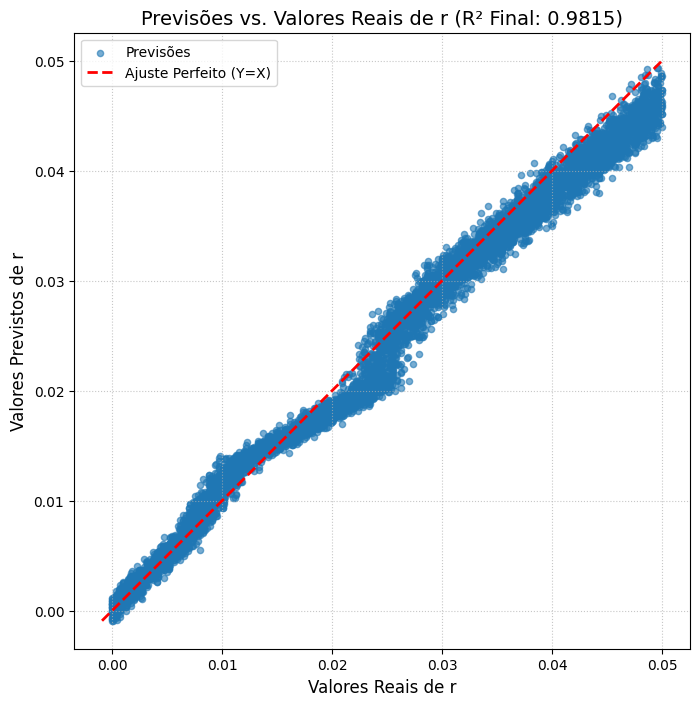

In [33]:
import matplotlib.pyplot as plt
import numpy as np

# Suponha que você já tem:
# y_true_original: valores verdadeiros de 'r' (na escala original)
# y_pred_original: valores previstos de 'r' (na escala original)

# Crie a linha de identidade X=Y
min_val = min(y_train.min(), y_pred_original.min())
max_val = max(y_train.max(), y_pred_original.max())
ideal_line = np.linspace(min_val, max_val, 100)

plt.figure(figsize=(8, 8))

# 1. Scatter Plot dos Resultados
plt.scatter(y_train, y_pred_original, alpha=0.6, s=20, label='Previsões')

# 2. Linha de Identidade (Ajuste Perfeito)
plt.plot(ideal_line, ideal_line, color='red', linestyle='--', linewidth=2, label='Ajuste Perfeito (Y=X)')

plt.title(f'Previsões vs. Valores Reais de r (R² Final: {final_r2:.4f})', fontsize=14)
plt.xlabel('Valores Reais de r', fontsize=12)
plt.ylabel('Valores Previstos de r', fontsize=12)
plt.legend()
plt.grid(True, linestyle=':', alpha=0.7)
plt.gca().set_aspect('equal', adjustable='box') # Garante que os eixos tenham a mesma escala
plt.show()

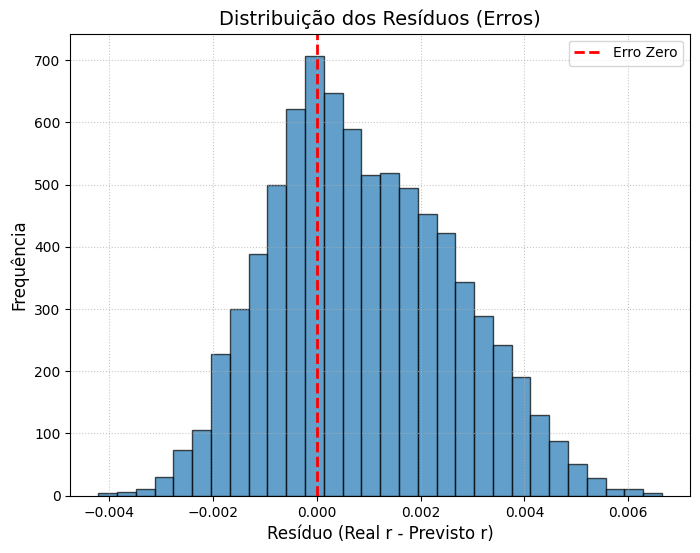

In [34]:
# Calcule os resíduos (True - Predicted)
residuals = y_true - y_pred_original

# Achata o array para 1D (o formato (N,))
residuals_1d = residuals.ravel()

plt.figure(figsize=(8, 6))

# Histograma dos resíduos
plt.hist(residuals_1d, bins=30, edgecolor='black', alpha=0.7)

# Linha vertical em zero (onde o centro do histograma deveria estar)
plt.axvline(x=0, color='red', linestyle='--', linewidth=2, label='Erro Zero')

plt.title('Distribuição dos Resíduos (Erros)', fontsize=14)
plt.xlabel('Resíduo (Real r - Previsto r)', fontsize=12)
plt.ylabel('Frequência', fontsize=12)
plt.legend()
plt.grid(True, linestyle=':', alpha=0.7)
plt.show()

## Obsevação

- Houve uma melhora nas métricas, mas fica evidente nas visualizações acima que houve uma piora nas previsões para valores muito baixo do target 'r'.

- O modelo tende a errar mais para valores de r próximos de 0. 

# Aplicando o modelo no conjunto de teste

In [35]:
teste = pd.read_csv('teste_b_df.csv')

In [36]:
teste

,l_2,l_3,l_4,l_5,l_6,l_7,l_8,l_9,l_10,l_11,...,l_503,l_504,l_505,l_506,l_507,l_508,l_509,l_510,l_511,r
0,0.000324,0.000231,0.000522,0.000442,0.000362,0.000169,0.000340,0.000088,0.000165,0.000080,...,6.354351e-10,6.187699e-10,5.472912e-10,5.294808e-10,4.588926e-10,4.831911e-10,4.436403e-10,4.468961e-10,3.870140e-10,0.012381
1,0.000151,0.000311,0.001109,0.000375,0.000294,0.000303,0.000097,0.000167,0.000160,0.000236,...,6.694943e-10,6.136765e-10,5.431460e-10,5.383948e-10,4.906521e-10,4.529458e-10,4.044472e-10,4.218503e-10,3.899587e-10,0.012381
2,0.000202,0.000149,0.000227,0.000125,0.000369,0.000214,0.000223,0.000248,0.000140,0.000113,...,6.146857e-10,5.446755e-10,5.413667e-10,4.347151e-10,4.661081e-10,4.313945e-10,4.091606e-10,3.493361e-10,4.023474e-10,0.012381
3,0.000220,0.000457,0.000355,0.000421,0.000318,0.000099,0.000261,0.000180,0.000138,0.000109,...,6.131173e-10,6.130531e-10,5.876743e-10,5.359379e-10,5.261903e-10,4.781340e-10,4.263396e-10,3.872770e-10,3.959668e-10,0.012381
4,0.000344,0.000149,0.000228,0.000236,0.000213,0.000378,0.000264,0.000188,0.000133,0.000094,...,6.410077e-10,5.819736e-10,5.628697e-10,5.259830e-10,4.852131e-10,4.648140e-10,3.990974e-10,4.037040e-10,3.888955e-10,0.012381
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,0.000017,0.000209,0.000385,0.000079,0.000089,0.000040,0.000053,0.000055,0.000056,0.000124,...,5.516829e-10,5.934444e-10,5.169918e-10,5.210142e-10,4.470891e-10,4.619118e-10,3.933742e-10,3.561920e-10,3.397018e-10,0.014936
1996,0.000021,0.000200,0.000087,0.000099,0.000158,0.000047,0.000015,0.000058,0.000137,0.000072,...,5.594487e-10,5.265735e-10,4.667441e-10,4.792801e-10,4.221269e-10,3.972213e-10,3.605560e-10,3.874225e-10,3.352761e-10,0.014936
1997,0.000244,0.000103,0.000202,0.000152,0.000073,0.000035,0.000057,0.000036,0.000052,0.000085,...,5.235341e-10,6.281461e-10,5.356119e-10,5.341638e-10,4.507673e-10,4.504032e-10,4.218950e-10,4.454599e-10,3.516340e-10,0.014936
1998,0.000029,0.000242,0.000166,0.000151,0.000074,0.000058,0.000049,0.000089,0.000043,0.000053,...,5.865421e-10,5.865462e-10,5.099055e-10,5.082683e-10,4.383359e-10,4.465953e-10,3.948185e-10,3.890945e-10,3.387430e-10,0.014936


In [37]:
X_test = teste.drop(columns=['r'])
y_test = teste['r']

## Criando features extras

Todas as features criadas para treinar o modelo devem também ser criadas ao se aplicar os dados de teste. 

In [38]:
X_test = cria_feature_media_ponderada(X_test)

In [39]:
X_test

,l_2,l_3,l_4,l_5,l_6,l_7,l_8,l_9,l_10,l_11,...,l_503,l_504,l_505,l_506,l_507,l_508,l_509,l_510,l_511,media_ponderada_Cls
0,0.000324,0.000231,0.000522,0.000442,0.000362,0.000169,0.000340,0.000088,0.000165,0.000080,...,6.354351e-10,6.187699e-10,5.472912e-10,5.294808e-10,4.588926e-10,4.831911e-10,4.436403e-10,4.468961e-10,3.870140e-10,0.000110
1,0.000151,0.000311,0.001109,0.000375,0.000294,0.000303,0.000097,0.000167,0.000160,0.000236,...,6.694943e-10,6.136765e-10,5.431460e-10,5.383948e-10,4.906521e-10,4.529458e-10,4.044472e-10,4.218503e-10,3.899587e-10,0.000109
2,0.000202,0.000149,0.000227,0.000125,0.000369,0.000214,0.000223,0.000248,0.000140,0.000113,...,6.146857e-10,5.446755e-10,5.413667e-10,4.347151e-10,4.661081e-10,4.313945e-10,4.091606e-10,3.493361e-10,4.023474e-10,0.000110
3,0.000220,0.000457,0.000355,0.000421,0.000318,0.000099,0.000261,0.000180,0.000138,0.000109,...,6.131173e-10,6.130531e-10,5.876743e-10,5.359379e-10,5.261903e-10,4.781340e-10,4.263396e-10,3.872770e-10,3.959668e-10,0.000110
4,0.000344,0.000149,0.000228,0.000236,0.000213,0.000378,0.000264,0.000188,0.000133,0.000094,...,6.410077e-10,5.819736e-10,5.628697e-10,5.259830e-10,4.852131e-10,4.648140e-10,3.990974e-10,4.037040e-10,3.888955e-10,0.000110
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,0.000017,0.000209,0.000385,0.000079,0.000089,0.000040,0.000053,0.000055,0.000056,0.000124,...,5.516829e-10,5.934444e-10,5.169918e-10,5.210142e-10,4.470891e-10,4.619118e-10,3.933742e-10,3.561920e-10,3.397018e-10,0.000102
1996,0.000021,0.000200,0.000087,0.000099,0.000158,0.000047,0.000015,0.000058,0.000137,0.000072,...,5.594487e-10,5.265735e-10,4.667441e-10,4.792801e-10,4.221269e-10,3.972213e-10,3.605560e-10,3.874225e-10,3.352761e-10,0.000103
1997,0.000244,0.000103,0.000202,0.000152,0.000073,0.000035,0.000057,0.000036,0.000052,0.000085,...,5.235341e-10,6.281461e-10,5.356119e-10,5.341638e-10,4.507673e-10,4.504032e-10,4.218950e-10,4.454599e-10,3.516340e-10,0.000102
1998,0.000029,0.000242,0.000166,0.000151,0.000074,0.000058,0.000049,0.000089,0.000043,0.000053,...,5.865421e-10,5.865462e-10,5.099055e-10,5.082683e-10,4.383359e-10,4.465953e-10,3.948185e-10,3.890945e-10,3.387430e-10,0.000102


## Selecionando features

In [40]:
X_test = X_test[selected_feature_names]

# Normalizando os dados de teste

In [41]:
X_test_scaled = X_scaler.fit_transform(X_test)

In [42]:
X_test_scaled

array([[0.07435633, 0.03692665, 0.07820612, ..., 0.3887842 , 0.40043629,
        0.4527851 ],
       [0.0345022 , 0.04971428, 0.16655969, ..., 0.48168876, 0.56589987,
        0.43330599],
       [0.04625197, 0.02367464, 0.03390572, ..., 0.44491754, 0.44176495,
        0.44502491],
       ...,
       [0.05592865, 0.0164072 , 0.03009316, ..., 0.47101597, 0.200977  ,
        0.29747154],
       [0.00669132, 0.03854449, 0.02475963, ..., 0.50256093, 0.44657156,
        0.29992303],
       [0.02253857, 0.03226719, 0.0216271 , ..., 0.42220334, 0.52028424,
        0.27672755]], shape=(2000, 150))

In [43]:
X_test_scaled.max()

np.float64(1.0000000000000002)

In [44]:
X_test_scaled.min()

np.float64(0.0)

In [45]:
# Escalonamento do Target (Y)
# Reformatar y_train para que o scaler funcione (de Series para 2D array/DataFrame)
y_test_2d = y_test.values.reshape(-1, 1)

# Obtem o melhor modelo do Halving Random Search
best_nn_model = hrs_result.best_estimator_

# A previsão é feita na escala Z-Score (escalada)
y_pred_test_scaled = best_nn_model.predict(X_test_scaled).reshape(-1, 1)

# Faz a transformação inversa para obter os valores em 'r':
y_pred_test_original = y_scaler.inverse_transform(y_pred_test_scaled)


print("Previsão no Conjunto de Teste concluída com sucesso.")

Previsão no Conjunto de Teste concluída com sucesso.


In [46]:
X_test_scaled.max()

np.float64(1.0000000000000002)

In [47]:
y_pred_test_scaled.max()

np.float32(1.0179076)

In [48]:
X_test_scaled.min()

np.float64(0.0)

In [49]:
y_pred_test_scaled.min()

np.float32(-0.0011646152)

In [50]:
y_pred_test_original.max()

np.float32(0.050893344)

In [51]:
y_pred_test_original.min()

np.float32(-5.822843e-05)

In [52]:
# Cálculo das 3 Métricas de Avaliação Finais:
mse_test = mean_squared_error(y_test_2d, y_pred_test_original)
mae_test = mean_absolute_error(y_test_2d, y_pred_test_original)
r2_test = r2_score(y_test_2d, y_pred_test_original)

print("\n" + "="*50)
print("AVALIAÇÃO DE DESEMPENHO NO CONJUNTO DE TESTE")
print("="*50)
print(f"MSE (Erro Quadrático Médio): {mse_test:.8f}")
print(f"MAE (Erro Absoluto Médio):   {mae_test:.8f} (Erro médio na unidade de 'r')")
print(f"R2 (Ajuste):                 {r2_test:.4f}")
print("="*50)


AVALIAÇÃO DE DESEMPENHO NO CONJUNTO DE TESTE
MSE (Erro Quadrático Médio): 0.00000251
MAE (Erro Absoluto Médio):   0.00123121 (Erro médio na unidade de 'r')
R2 (Ajuste):                 0.9877


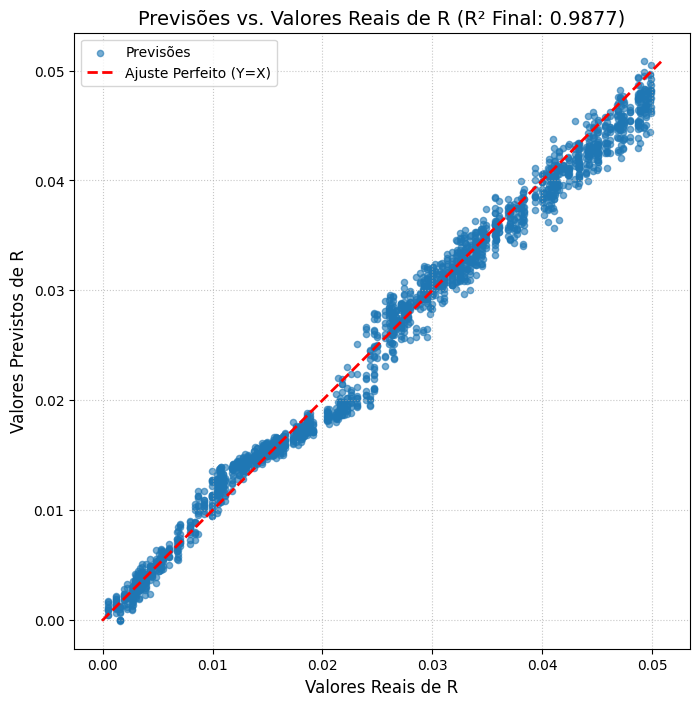

In [53]:
# Crie a linha de identidade X=Y
min_val = min(y_test_2d.min(), y_pred_test_original.min())
max_val = max(y_test_2d.max(), y_pred_test_original.max())
ideal_line = np.linspace(min_val, max_val, 100)

plt.figure(figsize=(8, 8))

# 1. Scatter Plot dos Resultados
plt.scatter(y_test_2d, y_pred_test_original, alpha=0.6, s=20, label='Previsões')

# 2. Linha de Identidade (Ajuste Perfeito)
plt.plot(ideal_line, ideal_line, color='red', linestyle='--', linewidth=2, label='Ajuste Perfeito (Y=X)')

plt.title(f'Previsões vs. Valores Reais de R (R² Final: {r2_test:.4f})', fontsize=14)
plt.xlabel('Valores Reais de R', fontsize=12)
plt.ylabel('Valores Previstos de R', fontsize=12)
plt.legend()
plt.grid(True, linestyle=':', alpha=0.7)
plt.gca().set_aspect('equal', adjustable='box') # Garante que os eixos tenham a mesma escala
plt.show()

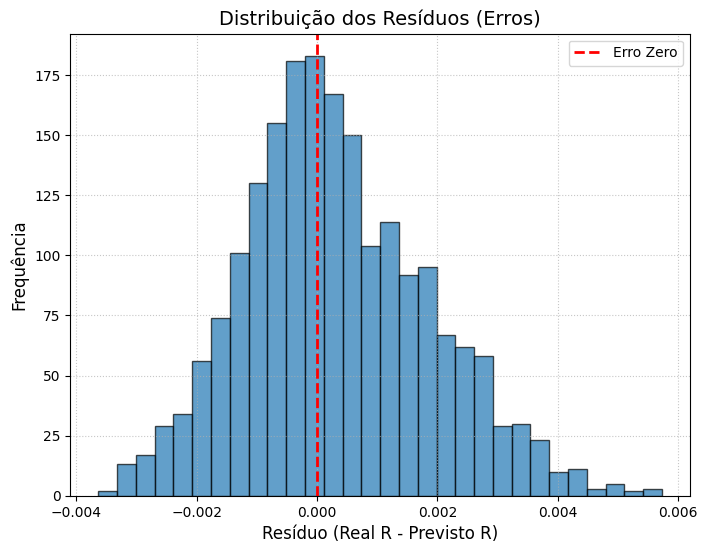

In [54]:


# Calcule os resíduos (True - Predicted)
residuals = y_test_2d - y_pred_test_original

# Achata o array para 1D (o formato (N,))
residuals_1d = residuals.ravel()

plt.figure(figsize=(8, 6))

# Histograma dos resíduos
plt.hist(residuals_1d, bins=30, edgecolor='black', alpha=0.7)

# Linha vertical em zero (onde o centro do histograma deveria estar)
plt.axvline(x=0, color='red', linestyle='--', linewidth=2, label='Erro Zero')

plt.title('Distribuição dos Resíduos (Erros)', fontsize=14)
plt.xlabel('Resíduo (Real R - Previsto R)', fontsize=12)
plt.ylabel('Frequência', fontsize=12)
plt.legend()
plt.grid(True, linestyle=':', alpha=0.7)
plt.show()

# Observação

- Ao utilizarmos apenas as 150 features mais importantes de acordo com o teste estatístico feito com o método da classe SelectKBest do scikit-learn, houve uma piora nas métricas do modelo. Principalmente na região central, onde  0.01 < r < 0.03.

# Sugestões para trabalhos futuros

- Fazer uma seleção de features utilizando-se um modelo linear, como, por exemplo, uma regressão linear.

- Testar o resultado do modelo eliminando menos features.

- Criar novas features com os dados de entrada.

- Aumentar a rede de parâmetros da validação cruzada.